<a href="https://colab.research.google.com/github/Vittori00/BB84-Protocol/blob/main/BB84_Vittori_603188.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Librerie principali (già installate in Colab con !pip install qiskit qiskit-aer matplotlib numpy)
!pip install qiskit qiskit-aer matplotlib numpy
!pip install pylatexenc
import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import display
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from scipy.special import comb

# *Versione Aggiornata*

In [2]:
# ==========================
# BB84 - Funzioni di utilità principali
# ==========================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from math import comb
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# BUILD BB84 CIRCUIT
# ==========================
def build_bb84(with_eve=False, draw=False):
    """
    Costruisce il circuito del protocollo BB84.
    Usa 2 o 3 qubit a seconda della presenza di Eve,
    con registri classici per bit e basi di Alice, Bob ed Eve.
    """
    if with_eve:
        qr = QuantumRegister(3, 'q')
        crAb = ClassicalRegister(1, 'cAb')  # Alice's basis choice
        crA = ClassicalRegister(1, 'cA')    # Alice's bit choice
        crB = ClassicalRegister(1, 'cB')    # Bob's basis choice
        crM = ClassicalRegister(1, 'cM')    # Bob's measurement
        crE = ClassicalRegister(1, 'cE')    # Eve's basis choice
        crME = ClassicalRegister(1, 'cM_eve')  # Eve's measurement
        qc = QuantumCircuit(qr, crM, crB, crA, crAb, crE, crME)
    else:
        qr = QuantumRegister(2, 'q')
        crAb = ClassicalRegister(1, 'cAb')
        crA = ClassicalRegister(1, 'cA')
        crB = ClassicalRegister(1, 'cB')
        crM = ClassicalRegister(1, 'cM')
        qc = QuantumCircuit(qr, crM, crB, crA, crAb)

    # Step 1: Alice chooses bit and basis
    # per misuriamo un qbit metto nello stato + cosi abbiamo 50 e 50
    # e siamo sicuri della randomicità
    qc.h(qr[0])
    qc.measure(qr[0], crA)  # random bit
    qc.reset(qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], crAb)  # random basis

    # Alice encodes the qubit based on her bit and basis
    with qc.if_test((crA, 1)):
        qc.x(qr[1])
    with qc.if_test((crAb, 1)):
        qc.h(qr[1])
    qc.barrier()

    # Step 2: Eve
    if with_eve:
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crE)

        if not draw:
            qc.id(qr[1])

        with qc.if_test((crE, 1)):
            qc.h(qr[1])
        qc.measure(qr[1], crME)

        with qc.if_test((crME, 1)):
            qc.x(qr[2])
        with qc.if_test((crE, 1)):
            qc.h(qr[2])
        qc.barrier()

        # Step 3: Bob chooses basis and measures
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crB)
        if not draw:
            qc.id(qr[2])
        with qc.if_test((crB, 1)):
            qc.h(qr[2])
        qc.measure(qr[2], crM)

    else: #senza Eve
        # Step 3: Bob chooses basis and measures
        qc.reset(qr[0])
        qc.h(qr[0])
        qc.measure(qr[0], crB)
        if not draw:
            qc.id(qr[1])
        with qc.if_test((crB, 1)):
            qc.h(qr[1])
        qc.measure(qr[1], crM)

    return qc


# ==========================
# SIMULATE BB84
# ==========================
def simulate(qc, noise_type=None, p=0.01, shots=300, with_eve=False):
    """
    Simula l’esecuzione del circuito BB84 (con o senza Eve) sotto diversi tipi di rumore.
    Restituisce: (L, R_mis, P_keep)
    """
    # Costruzione del noise model
    bitflip_q1 = pauli_error([('X', p), ('I', 1 - p)])
    phaseflip_q1 = pauli_error([('Z', p), ('I', 1 - p)])
    bitphaseflip_q1 = pauli_error([('Y', p), ('I', 1 - p)])
    noise_model = NoiseModel()

    if noise_type == 'bitflip':
        noise_model.add_quantum_error(bitflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(bitflip_q1, ['id'], [2])
    elif noise_type == 'phaseflip':
        noise_model.add_quantum_error(phaseflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(phaseflip_q1, ['id'], [2])
    elif noise_type == 'bitphaseflip':
        noise_model.add_quantum_error(bitphaseflip_q1, ['id'], [1])
        if with_eve:
            noise_model.add_quantum_error(bitphaseflip_q1, ['id'], [2])

    # Esecuzione
    backend = AerSimulator(noise_model=noise_model)
    circ = transpile(qc, backend, optimization_level=0)
    job = backend.run(circ, shots=shots, memory=True)
    mem = job.result().get_memory()

    cA, cAb, cB, cM = [], [], [], []
    for shot in mem:
        bits = list(map(int, shot.replace(' ', '')[::-1]))
        # Ordine coerente con dichiarazione dei registri
        if len(bits) >= 4:
            m, b, a, ab = bits[:4]
            cM.append(m)
            cB.append(b)
            cA.append(a)
            cAb.append(ab)

    cA, cAb, cB, cM = map(np.array, (cA, cAb, cB, cM))

    # Sifting: Bob tiene solo quando base uguale
    keep_mask = (cAb == cB)
    alice_key = cA[keep_mask]
    bob_key = cM[keep_mask]

    L = len(alice_key)
    R_mis = np.mean(alice_key != bob_key) if L > 0 else 0
    P_keep = np.mean(keep_mask)

    return L, R_mis, P_keep
# ==========================
# 3) simulate_multiple_times (same interface)
# ==========================
def simulate_multiple_times(qc, noise_type=None, p=0, n_repeats=10, n_shots=300, with_eve=False):
    """
    Ripete simulate() n_repeats volte per ottenere medie e CI.
    Restituisce: L_mean, mismatch_mean(%), keep_mean(%), mismatch_ci, keep_ci
    (stesso output style della versione B92 che mi hai dato)
    """
    mismatch_ratios = []
    keep_ratios = []
    Ls = []

    for _ in range(n_repeats):
        L_val, R_mis, P_keep = simulate(qc, noise_type=noise_type, p=p, shots=n_shots, with_eve=with_eve)
        # convert to percentages to match plotting style in original assignment_7
        mismatch_ratios.append(R_mis * 100 if R_mis is not None else 0.0)
        keep_ratios.append(P_keep * 100)
        Ls.append(L_val)

    mismatch_mean = np.mean(mismatch_ratios)
    keep_mean = np.mean(keep_ratios)
    L_mean = np.mean(Ls)

    mismatch_std = np.std(mismatch_ratios, ddof=0)
    keep_std = np.std(keep_ratios, ddof=0)

    # 95% CI using normal approximation
    mismatch_ci = 1.96 * mismatch_std / np.sqrt(max(1, n_repeats))
    keep_ci = 1.96 * keep_std / np.sqrt(max(1, n_repeats))

    return L_mean, mismatch_mean, keep_mean, mismatch_ci, keep_ci

# ==========================
# 4) plot_mismatch_keep_curve
# ==========================
def plot_mismatch_keep_curve(qc, noise_type, p_values, n_repeats=30, n_shots=300, with_eve=False):
    mismatch_means = []
    keep_means = []
    mismatch_cis = []
    keep_cis = []

    for p in p_values:
        L, mismatch_mean, keep_mean, mismatch_ci, keep_ci = simulate_multiple_times(
            qc, noise_type=noise_type, p=p, n_repeats=n_repeats, n_shots=n_shots, with_eve=with_eve
        )
        mismatch_means.append(mismatch_mean)
        keep_means.append(keep_mean)
        mismatch_cis.append(mismatch_ci)
        keep_cis.append(keep_ci)

    # Primary figure
    plt.figure(figsize=(12, 8))
    plt.errorbar(p_values, mismatch_means, yerr=mismatch_cis, fmt='-o',
                 label=f'Mismatch Ratio', color='red', capsize=5)
    plt.errorbar(p_values, keep_means, yerr=keep_cis, fmt='-o',
                 label=f'Keep Ratio', color='blue', capsize=5)
    plt.xlabel('Probability Error p', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title(f'Mismatch and Keep Curve for {noise_type} Errors (BB84)', fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 100)
    plt.xticks(np.arange(0, 1.05, 0.05))
    plt.yticks(np.arange(0, 101, 5))
    plt.legend()
    plt.grid()
    plt.show()

    # Custom styled figure (transparent background)
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='none')
    ax.set_facecolor('none')

    ax.errorbar(p_values, keep_means, yerr=keep_cis, fmt='-o',
                label=f'Keep Ratio', color='#4EA5D9', ecolor='#4EA5D9',
                markerfacecolor='black', capsize=5)
    ax.errorbar(p_values, mismatch_means, yerr=mismatch_cis, fmt='-o',
                label=f'Mismatch Ratio', color='#E58C8A', ecolor='#E58C8A',
                markerfacecolor='black', capsize=5)

    ax.set_xlabel("Probability Error p", fontsize=14, color='black')
    ax.set_ylabel("Percentage", fontsize=14, color='black')
    ax.set_title(f"Mismatch and Keep Curve for {noise_type} Errors (BB84)", fontsize=16, color='black')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(0, 1.05, 0.05))
    ax.set_yticks(np.arange(0, 101, 5))

    ax.grid(True, linestyle='--', color='black', alpha=0.3)
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_color('black')

    legend = ax.legend(facecolor='none', edgecolor='black', fontsize=12)
    for text in legend.get_texts():
        text.set_color('black')

    plt.tight_layout()
    # try to save image folder if needed
    try:
        plt.savefig(f"images/slide_nuove/mismatch_keep_curve_bb84_{with_eve}_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)

# ==========================
# 5) p_undetected and plot_p_undetected_vs_k
# ==========================
def p_undetected(L, R_mis, k):
    """
    Probabilità che Eve rimanga non rilevata se si controlla una frazione k della chiave di lunghezza L
    R_mis is fraction of mismatches among sifted bits (not percentage)
    """
    L = int(round(L))
    M = int(round(R_mis * L)) if L else 0
    s = int(round(k * L)) if L else 0
    if s == 0:
        return 1.0
    if M == 0:
        return 1.0
    if s > L or M > L or L - M < s:
        return 0.0
    return comb(L - M, s, exact=True) / comb(L, s, exact=True)

def plot_p_undetected_vs_k(L, R_mis, k_values, noise_type=None):
    p_undetected_values = [p_undetected(L, R_mis, k) for k in k_values]
    x_vals = np.array(k_values) * 100

    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, p_undetected_values, marker='o', color='green', label='P(undetected)')
    plt.xlabel('k (%) of final bits checked', fontsize=14)
    plt.ylabel('Probability Eve is undetected', fontsize=14)
    plt.title(f'Probability of Eve Remaining Undetected (BB84, error={noise_type})', fontsize=16)
    plt.grid(True)
    plt.show()

    # Transparent styled plot for saving
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
    ax.set_facecolor('none')
    ax.plot(x_vals, p_undetected_values, marker='o', color='#E6AF2E', label='P(undetected)')
    ax.set_xlabel('k (%) of final bits checked', fontsize=14, color='black')
    ax.set_ylabel('Probability Eve is undetected', fontsize=14, color='black')
    ax.set_title(f'Probability of Eve Remaining Undetected (BB84, error={noise_type})', fontsize=16, color='black')
    ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.3)
    plt.tight_layout()
    try:
        plt.savefig(f"p_undetected_bb84_{noise_type}.png", transparent=True, dpi=300)
    except Exception:
        pass
    plt.close(fig)

# ==========================
# 6) plot_all_mismatch_keep_curves (multi L layout)
# ==========================
def plot_all_mismatch_keep_curves(qc, noise_type, p_values, n_repeats, with_eve=False):
    # Example L_values (user had n_shots list) -> we interpret them as different L_init to compare
    L_values = [50, 100, 300, 700, 1000, 1500]
    results_per_L = []

    fig, axes = plt.subplots(2, 3, figsize=(40, 18))
    axes = axes.flatten()

    for idx, L in enumerate(L_values):
        mismatches = []
        keeps = []
        mismatch_cis = []
        keep_cis = []
        for p in p_values:
            # Build a fresh circuit tailored to with_eve for fairness
            qc_round = qc  # the provided qc is a template; simulate_multiple_times uses qc directly
            L_mean, mm, km, mm_ci, km_ci = simulate_multiple_times(qc_round, noise_type=noise_type, p=p,
                                                                   n_repeats=n_repeats, n_shots=L, with_eve=with_eve)
            mismatches.append(mm)
            keeps.append(km)
            mismatch_cis.append(mm_ci)
            keep_cis.append(km_ci)

        ax = axes[idx]
        ax.errorbar(p_values, mismatches, yerr=mismatch_cis, fmt='-o', color='red', label='Mismatch')
        ax.errorbar(p_values, keeps, yerr=keep_cis, fmt='-o', color='blue', label='Keep')
        ax.set_title(f'L_init= {L}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 100)
        ax.grid(True)
        ax.legend()

    fig.suptitle(f'Mismatch and Keep Ratios for {noise_type} Errors Across Different L_init (BB84)', fontsize=18)
    plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
    plt.show()

# ==========================
# 7) p_undetected_mod and plot_all_p_undetected_curves
# ==========================
def p_undetected_mod(L, R_mis, k):
    return p_undetected(L, R_mis, k)

def plot_all_p_undetected_curves(qc, noise_type, p, n_repeats, with_eve=False):
    L_values = [50, 100, 300, 700, 1000, 1500]

    fig, axes = plt.subplots(2, 3, figsize=(40, 18))
    axes = axes.flatten()

    for idx, L in enumerate(L_values):
        # choose k grid based on L as in your original
        if L in [50]:
            k_values = np.arange(0, 51, 3) / 100
        elif L in [100]:
            k_values = np.arange(0, 31, 2) / 100
        else:
            k_values = np.arange(0, 21, 1) / 100

        # simulate to obtain L_mean and R_mis. We'll use n_shots = L for each simulate_multiple_times call.
        L_mean, R_mis_percent, _, _, _ = simulate_multiple_times(qc, noise_type=noise_type, p=p,
                                                                 n_repeats=n_repeats, n_shots=L, with_eve=with_eve)
        R_mis = (R_mis_percent / 100.0)
        p_undetected_values = [p_undetected_mod(L_mean, R_mis, k) for k in k_values]

        ax = axes[idx]
        ax.plot(k_values * 100, p_undetected_values, marker='o', color='green', label='P(undetected)')
        ax.set_title(f'L_init = {L}', fontsize=14)
        ax.set_xlim(0, max(k_values) * 100)
        ax.set_ylim(0, 1.05)
        ax.grid(True)
        ax.set_xlabel('k (%) of final bits checked', fontsize=12)
        ax.set_ylabel('P(Eve undetected)', fontsize=12)
        ax.legend()

    fig.suptitle(f'P_undetected vs k for {noise_type} errors at different L_init (BB84)', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

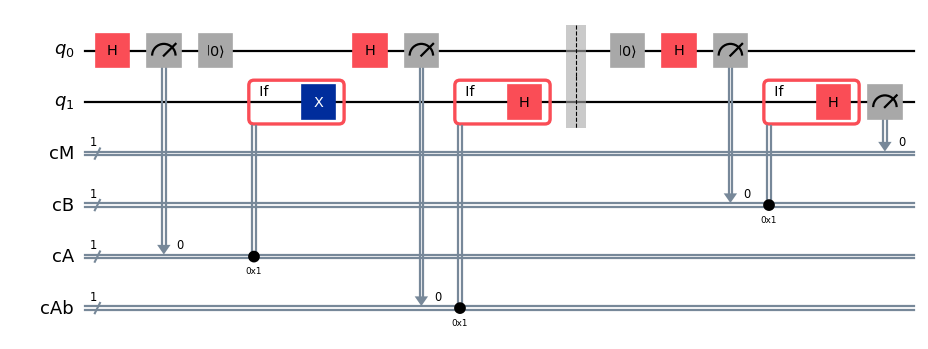

In [3]:
qc = build_bb84(with_eve=False, draw=True)
display(qc.draw('mpl', idle_wires=False, scale=0.8))

In [4]:
qc = build_bb84(with_eve=False)
p_values = np.arange(0, 1.05, 0.05)

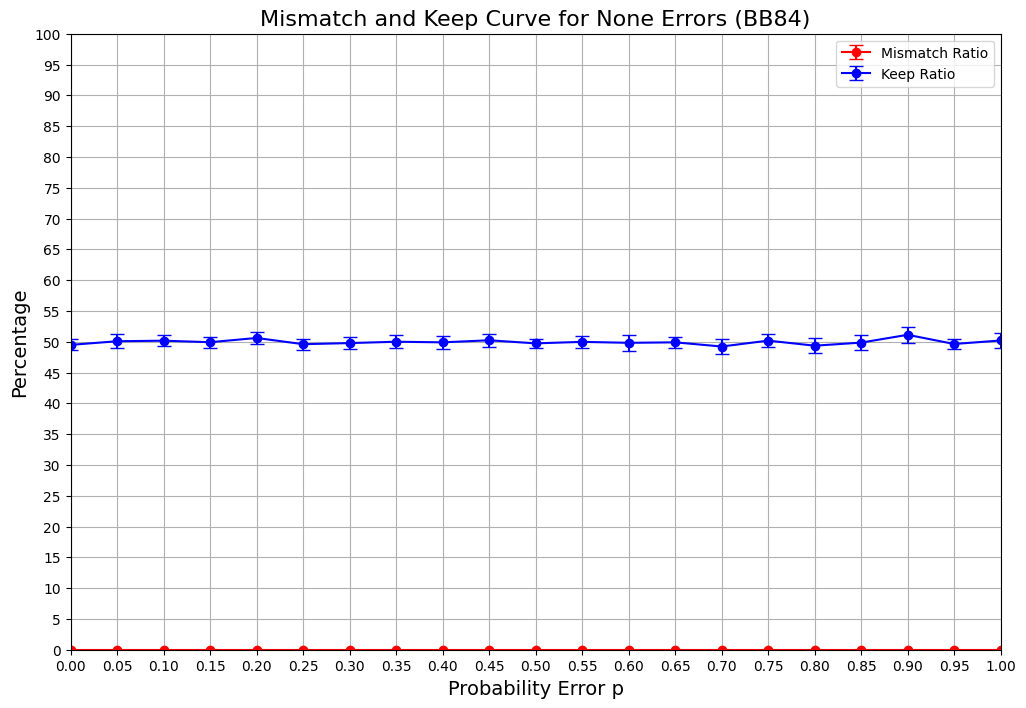

In [5]:
plot_mismatch_keep_curve(qc, noise_type=None, p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

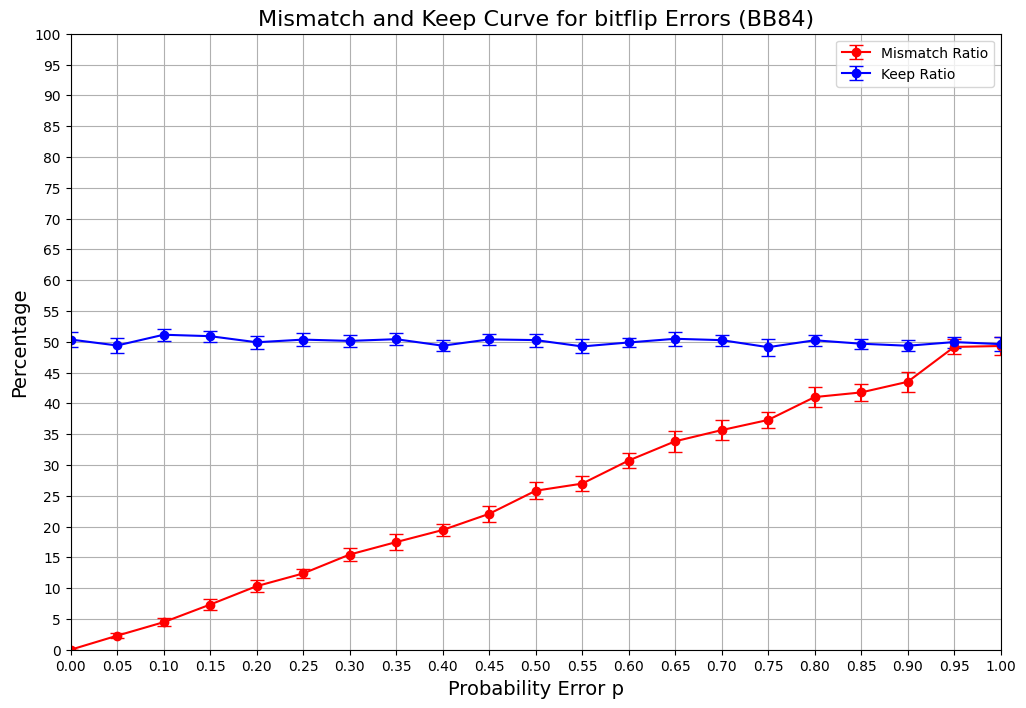

In [6]:
plot_mismatch_keep_curve(qc, noise_type="bitflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

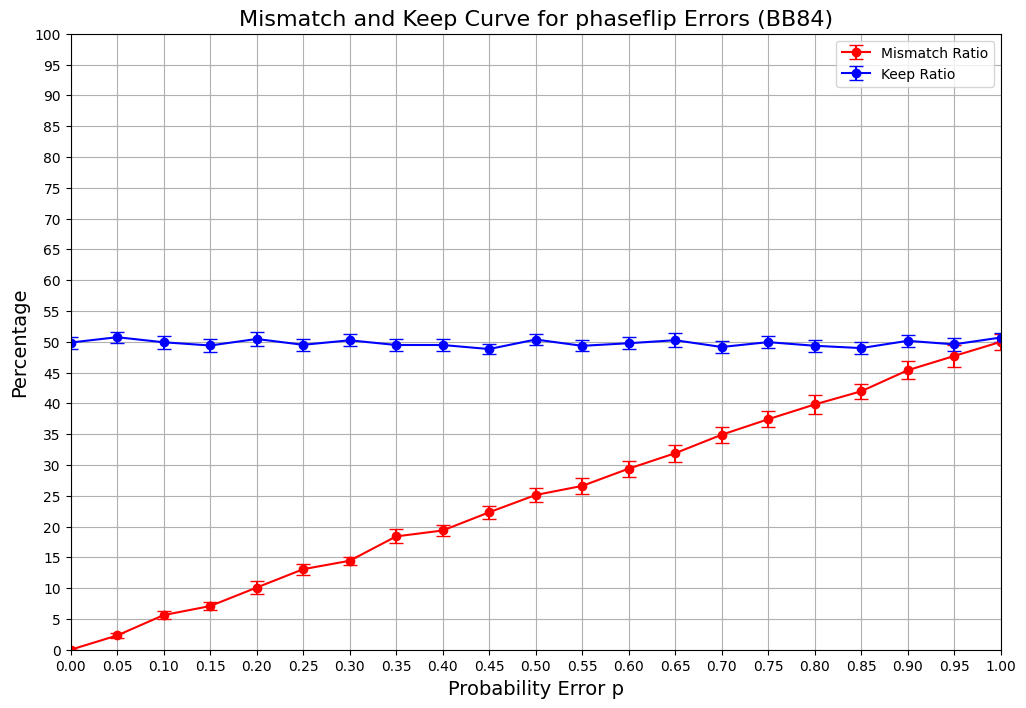

In [7]:
plot_mismatch_keep_curve(qc, noise_type="phaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

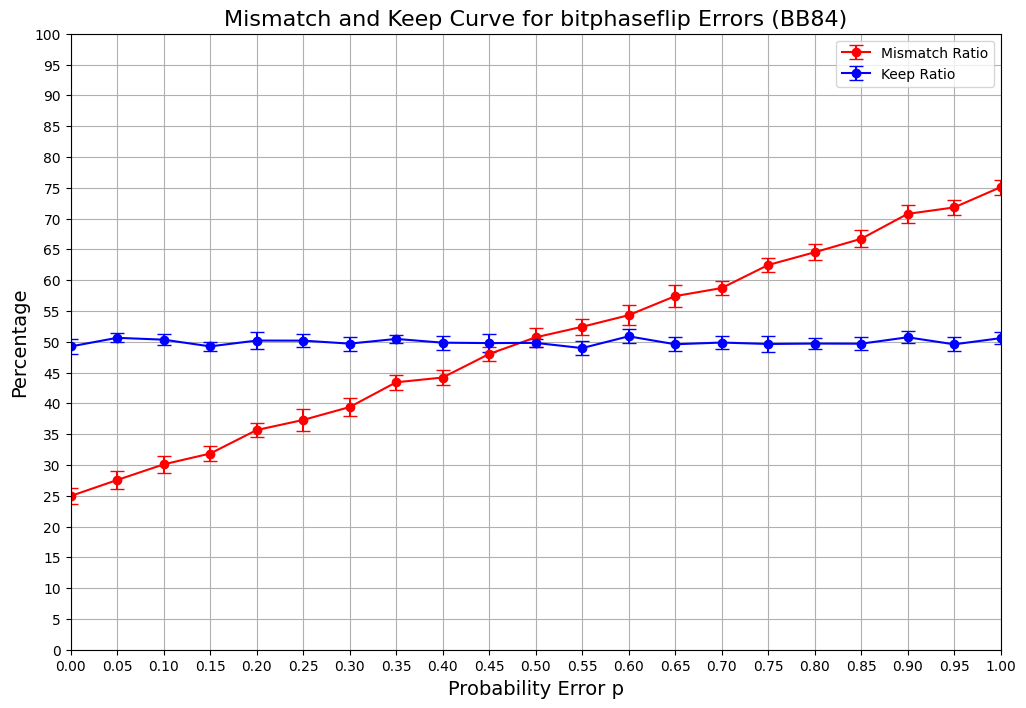

In [23]:
plot_mismatch_keep_curve(qc, noise_type="bitphaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=False)

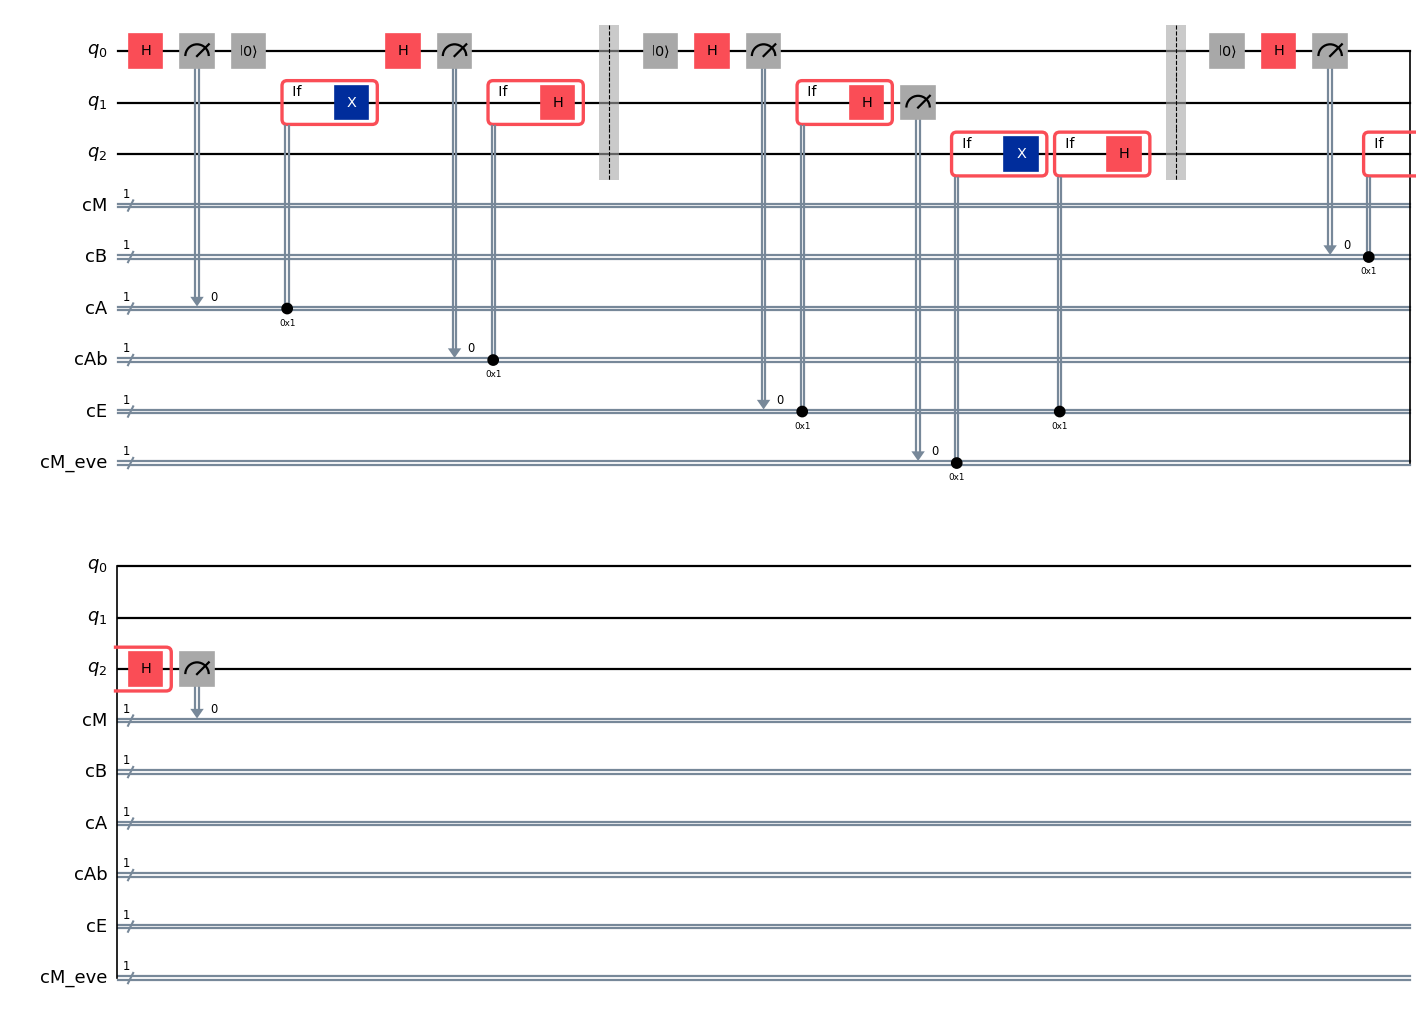

In [9]:
qc = build_bb84(with_eve=True, draw=True)
display(qc.draw('mpl', idle_wires=False, scale=0.8))

In [10]:
qc = build_bb84(with_eve=True, draw=False)
p_values = np.arange(0, 1.05, 0.05)

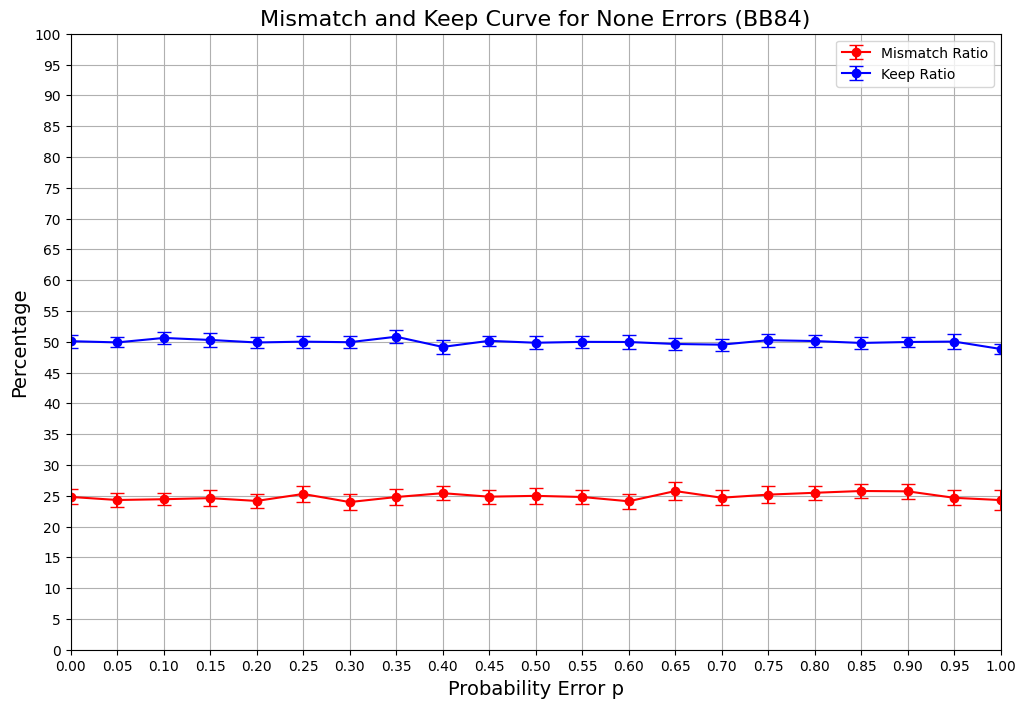

In [11]:
plot_mismatch_keep_curve(qc, noise_type=None, p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

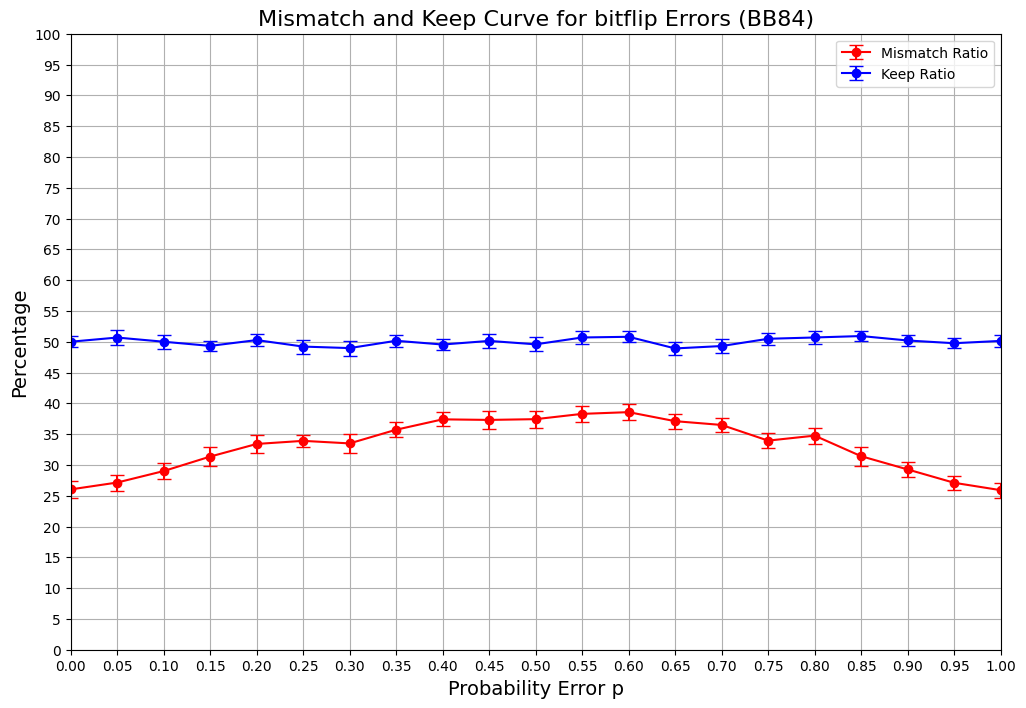

In [12]:
plot_mismatch_keep_curve(qc, noise_type="bitflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

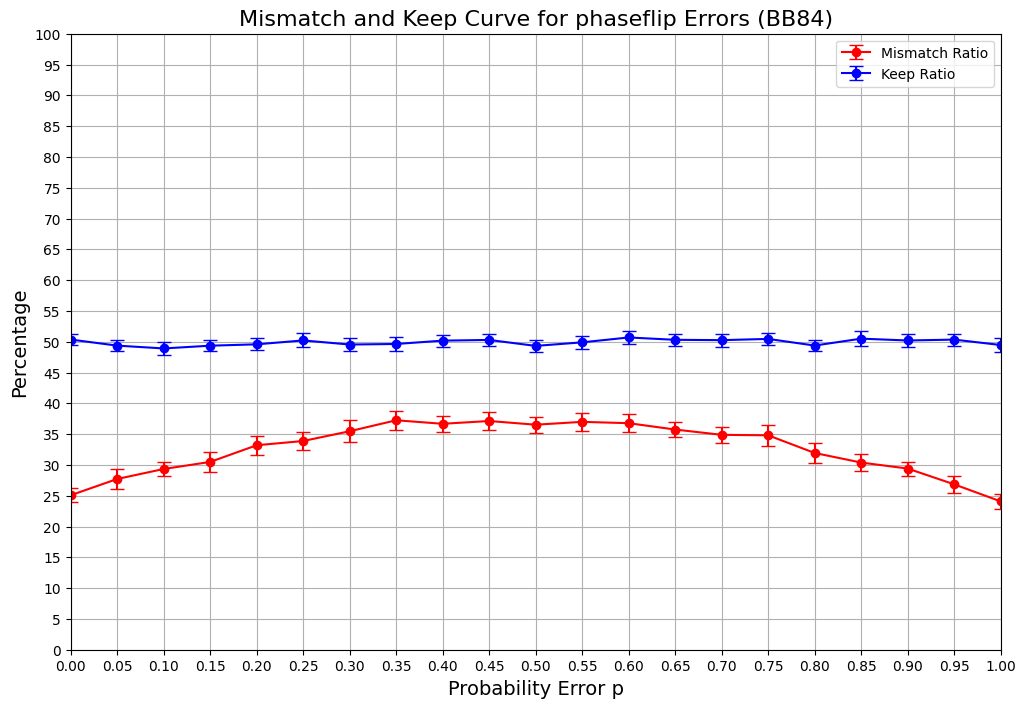

In [13]:
plot_mismatch_keep_curve(qc, noise_type="phaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

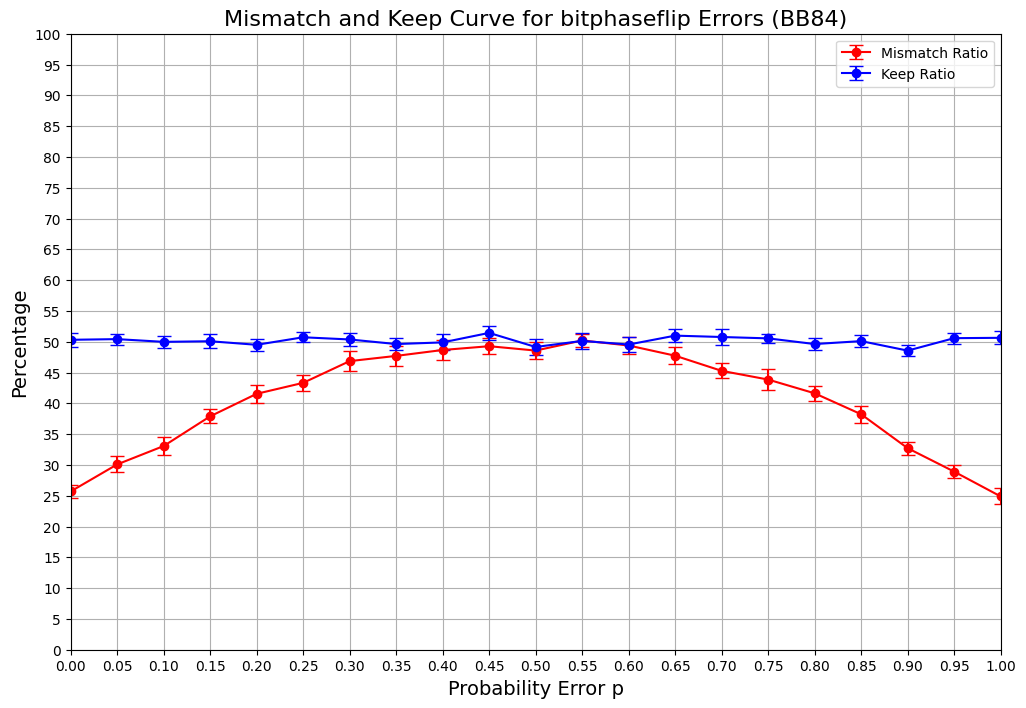

In [14]:
plot_mismatch_keep_curve(qc, noise_type="bitphaseflip", p_values=p_values,n_repeats=30, n_shots=300, with_eve=True)

In [15]:
k_values = np.arange(0, 21, 1) / 100

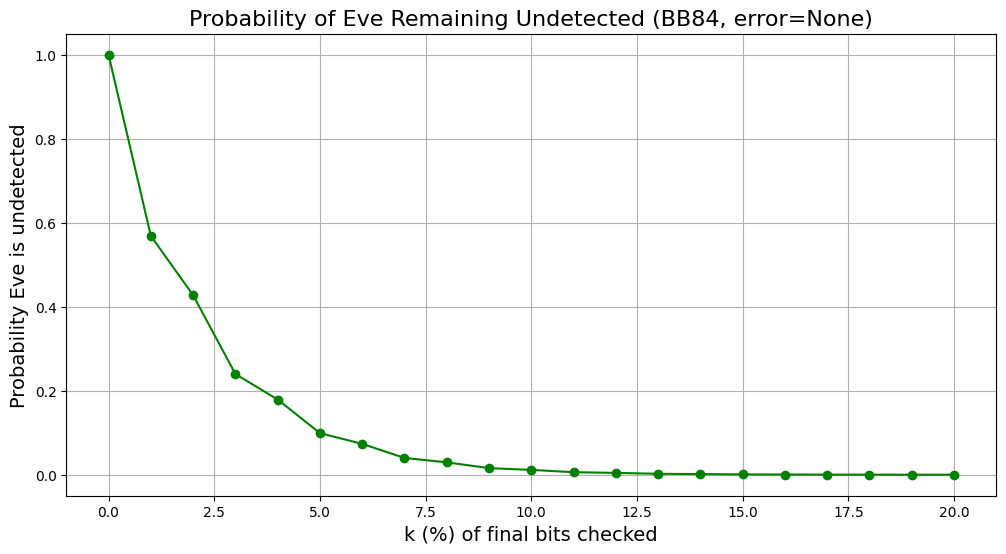

In [19]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type=None, p=0, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type=None)

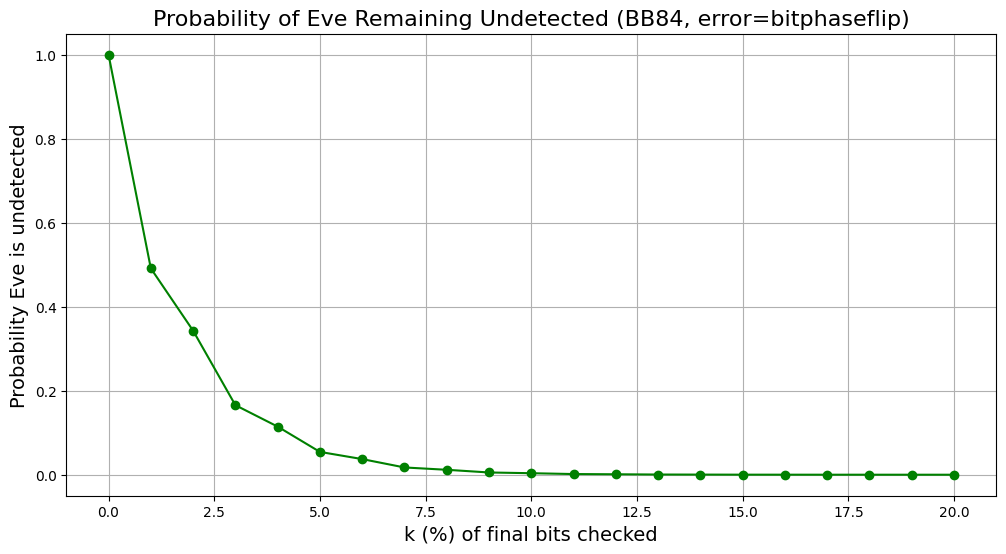

In [20]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='bitflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='bitphaseflip')

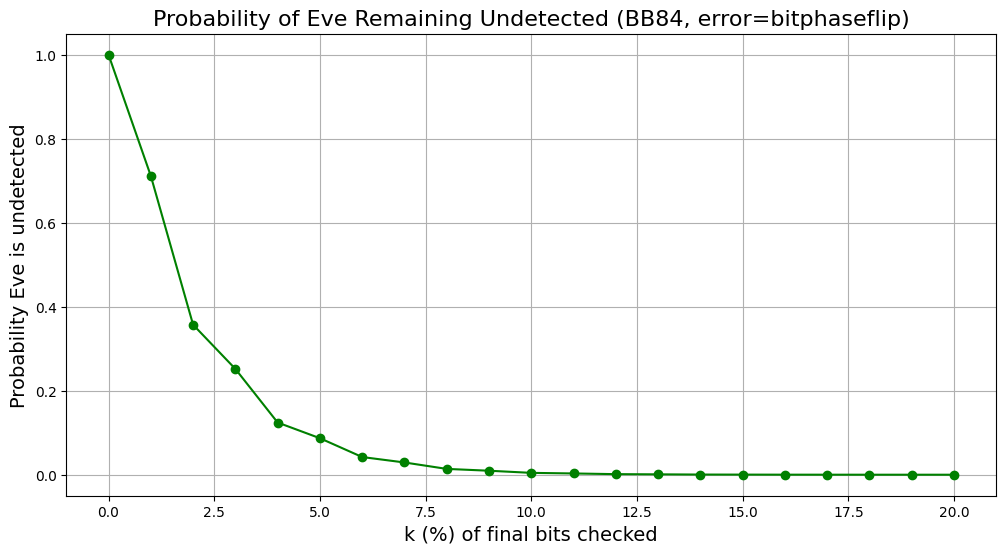

In [21]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='phaseflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='bitphaseflip')

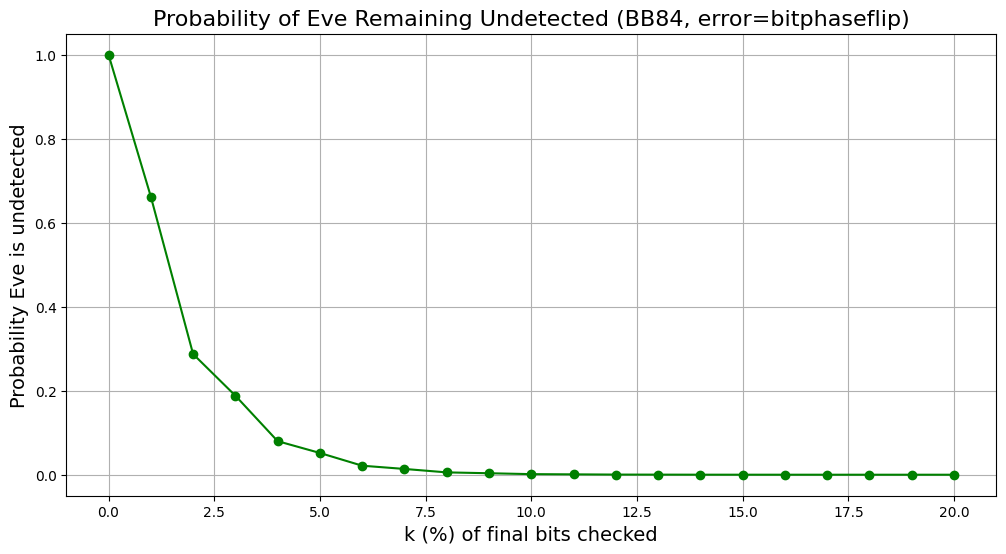

In [22]:
L, R_mis, _, _,_ = simulate_multiple_times(qc, noise_type='bitphaseflip', p=0.1, n_repeats=30, n_shots=300, with_eve=True)
R_mis = R_mis/100
plot_p_undetected_vs_k(L, R_mis, k_values, noise_type='bitphaseflip')

In [28]:
qc = build_bb84(with_eve=False)
p_values = np.arange(0, 1.05, 0.05)

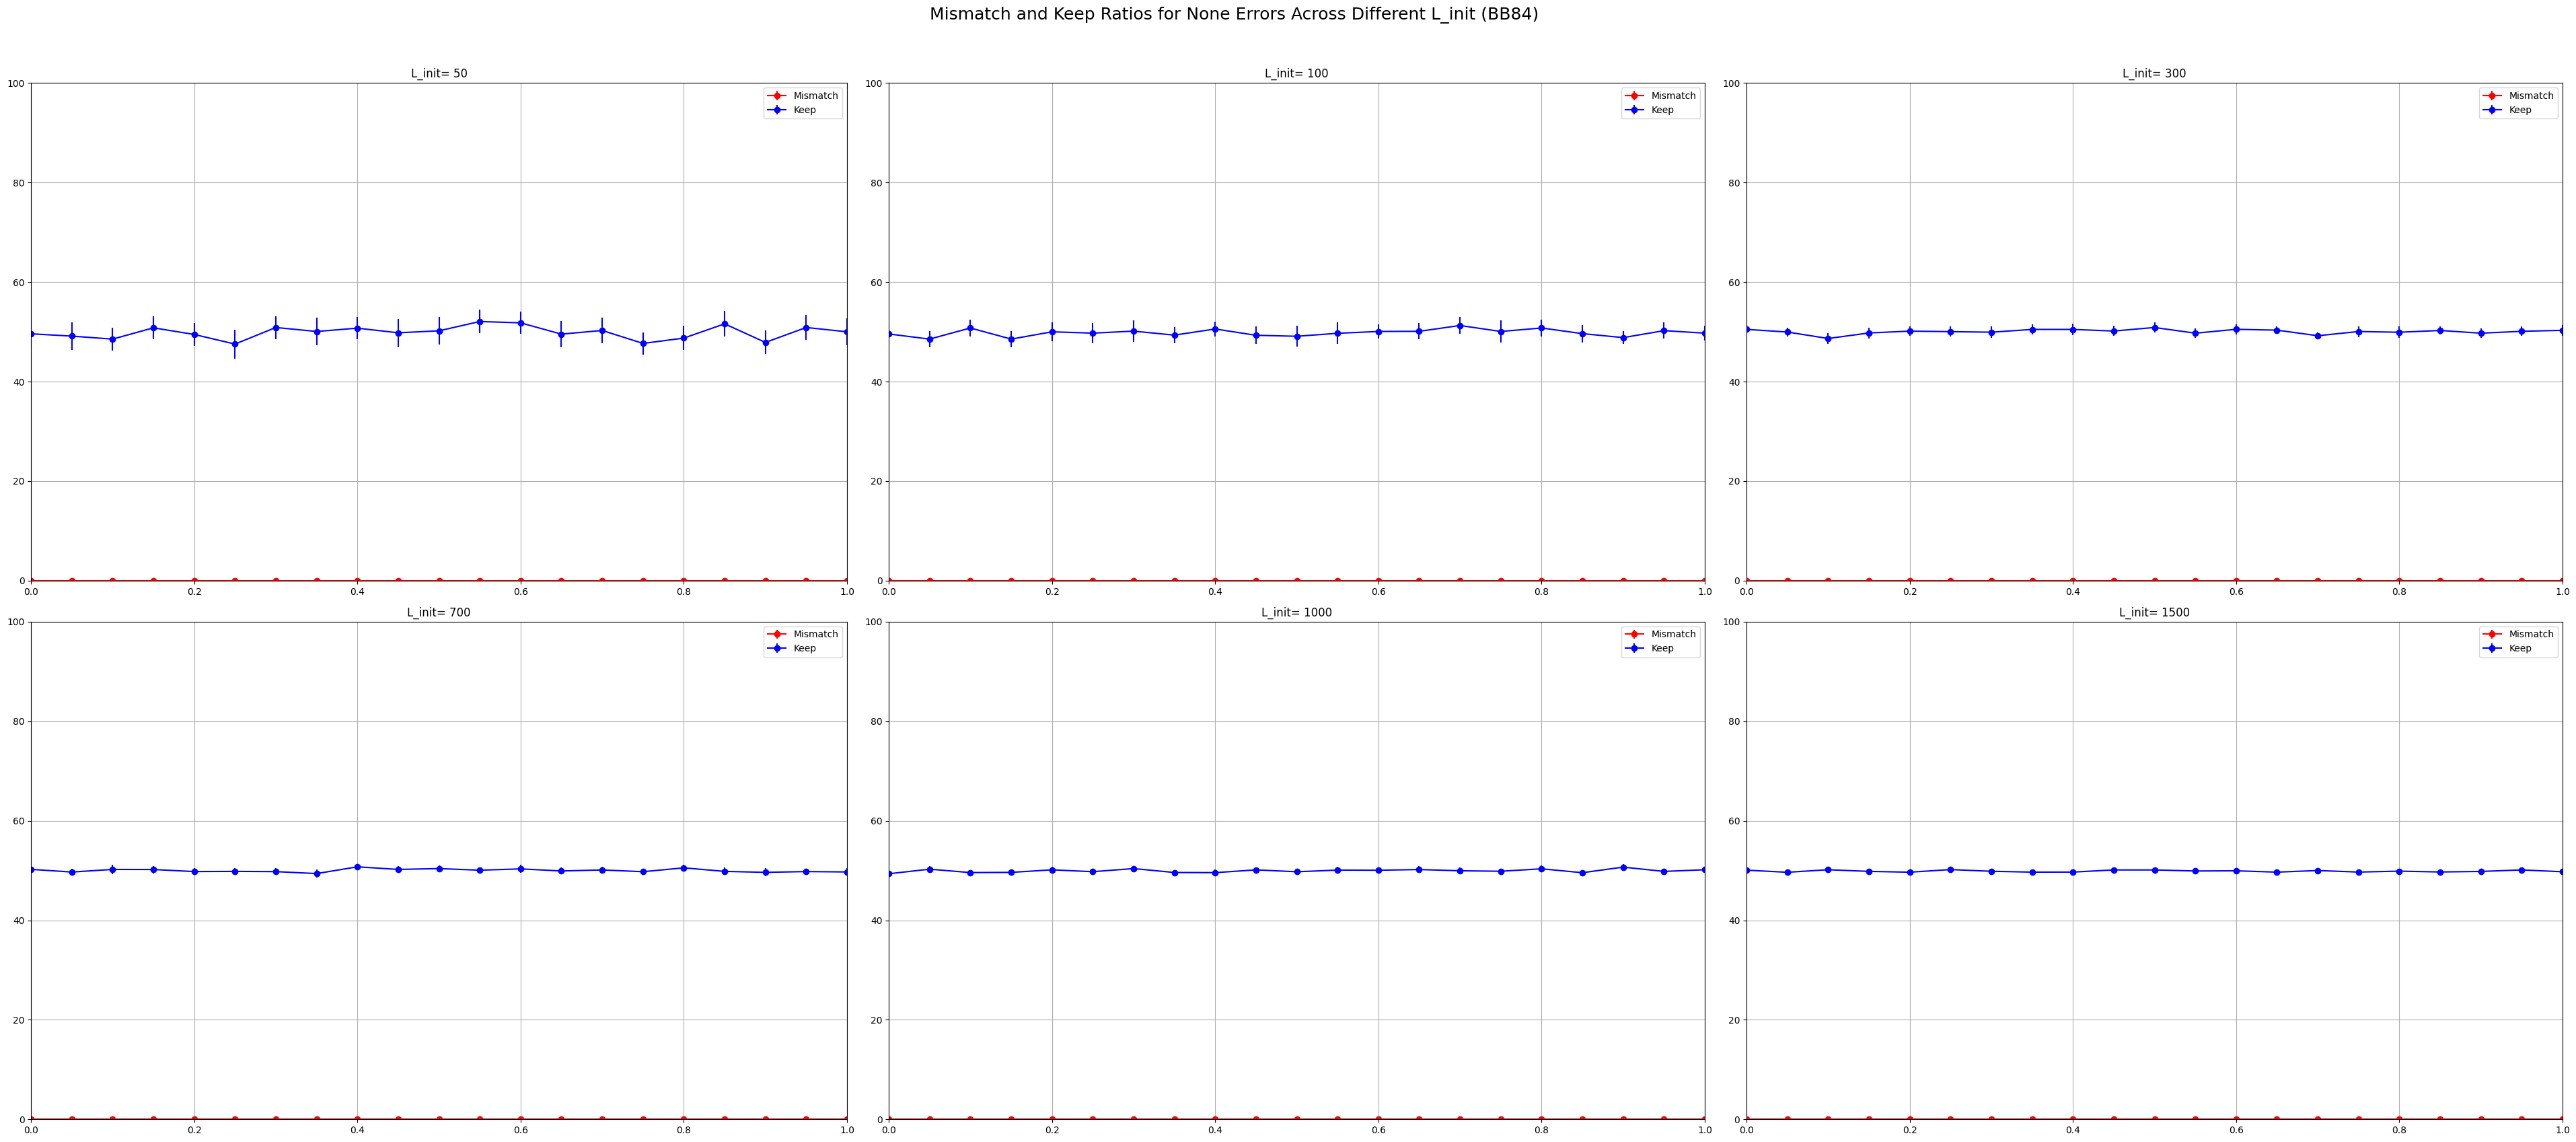

In [31]:
plot_all_mismatch_keep_curves(qc, None , p_values, n_repeats=30, with_eve=False)

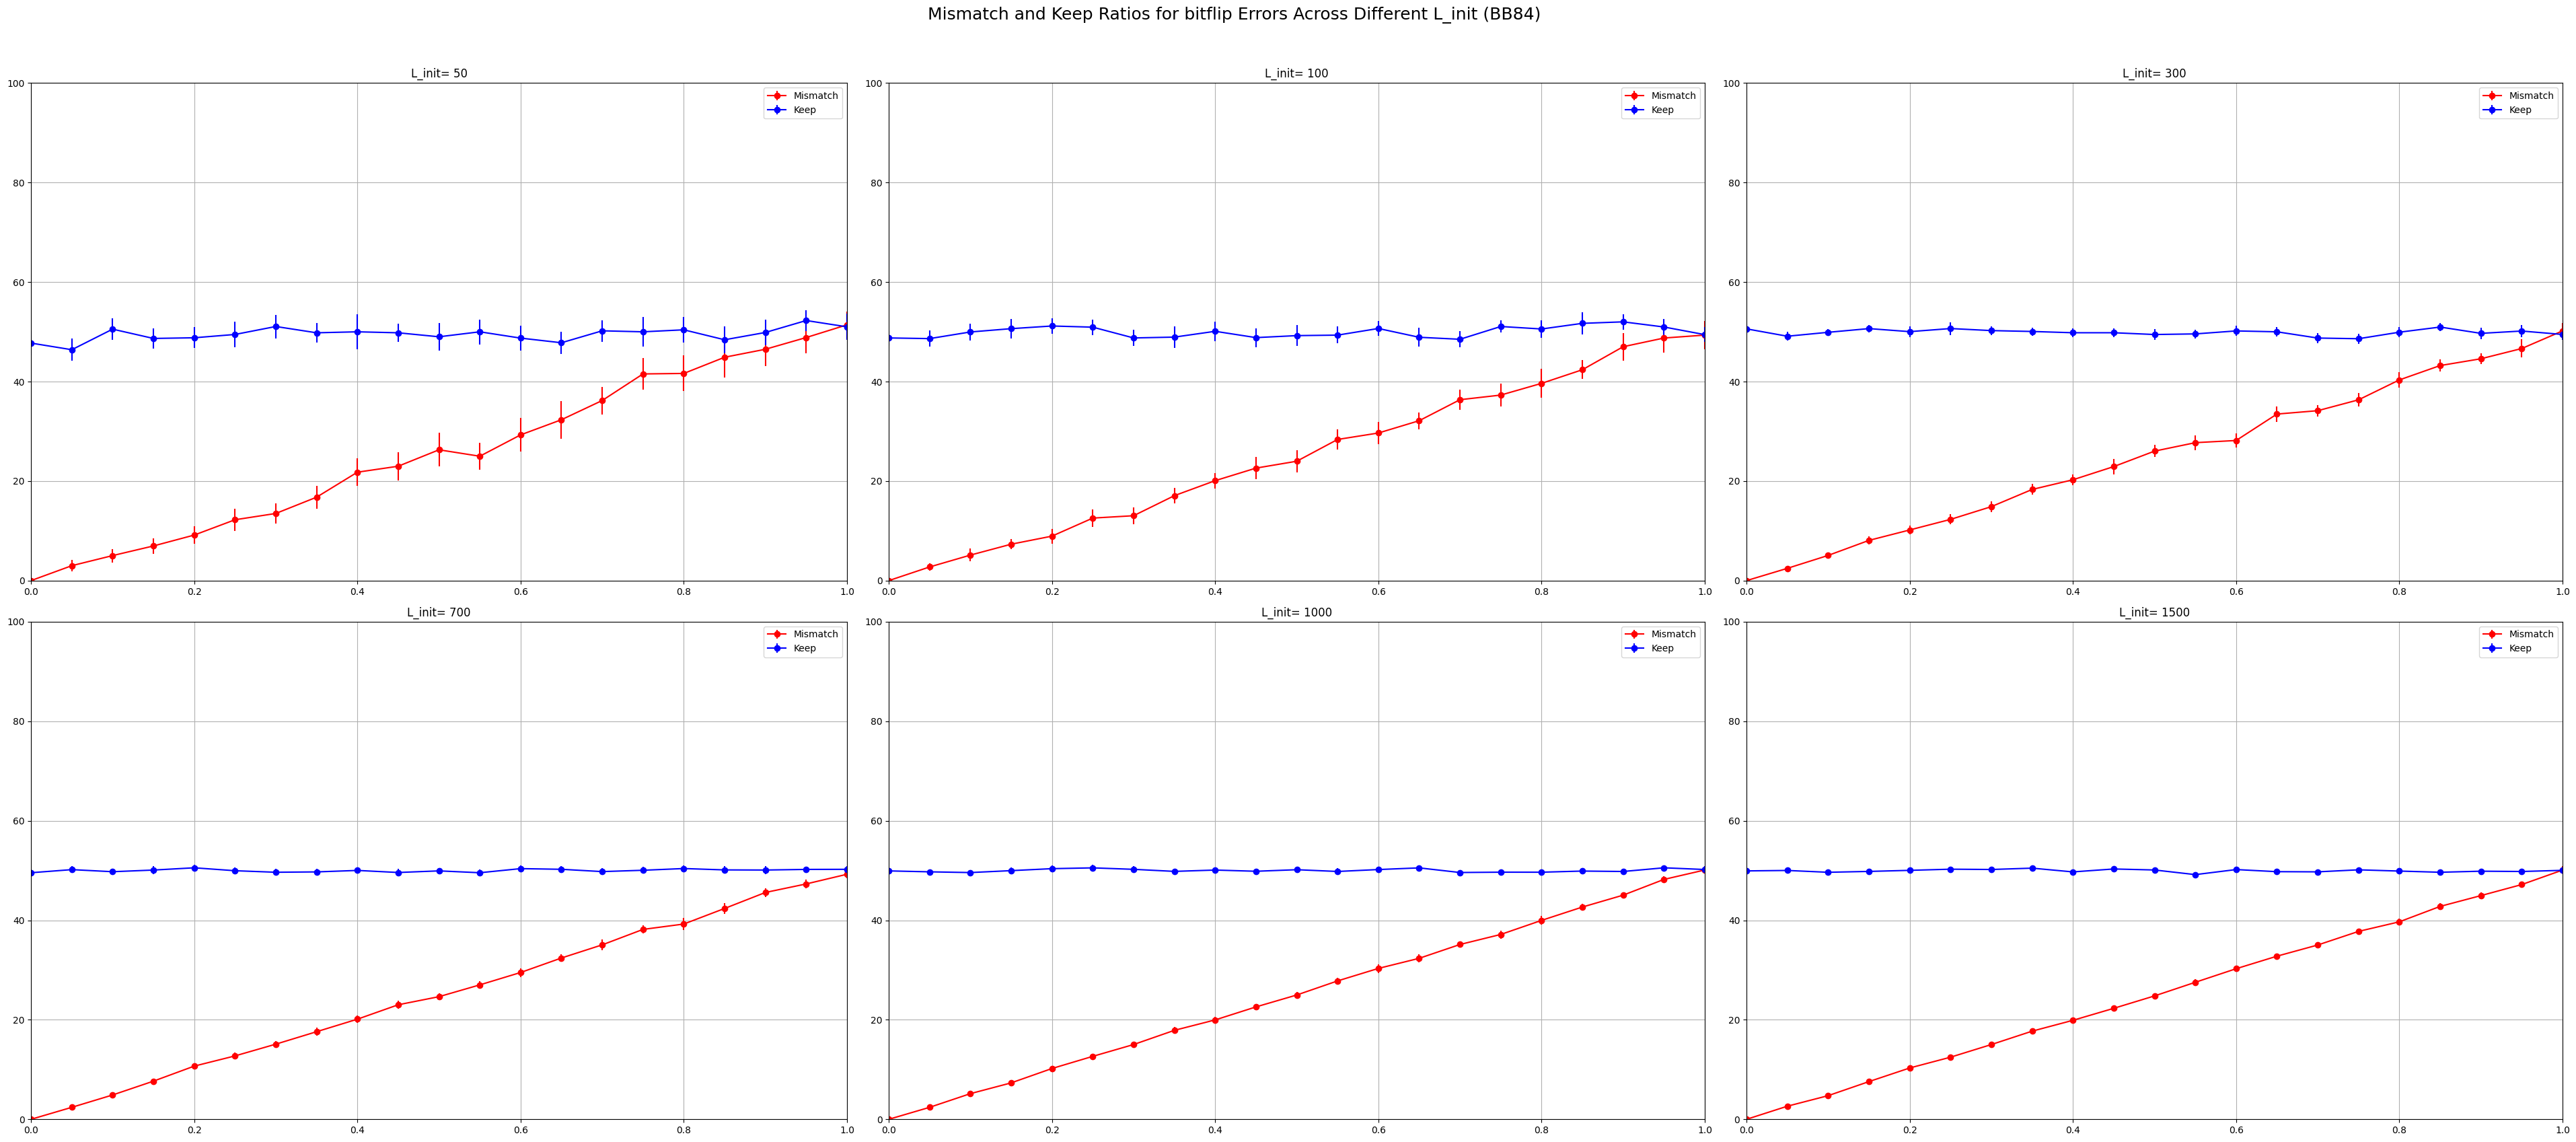

In [32]:
plot_all_mismatch_keep_curves(qc, "bitflip" , p_values, n_repeats=30, with_eve=False)

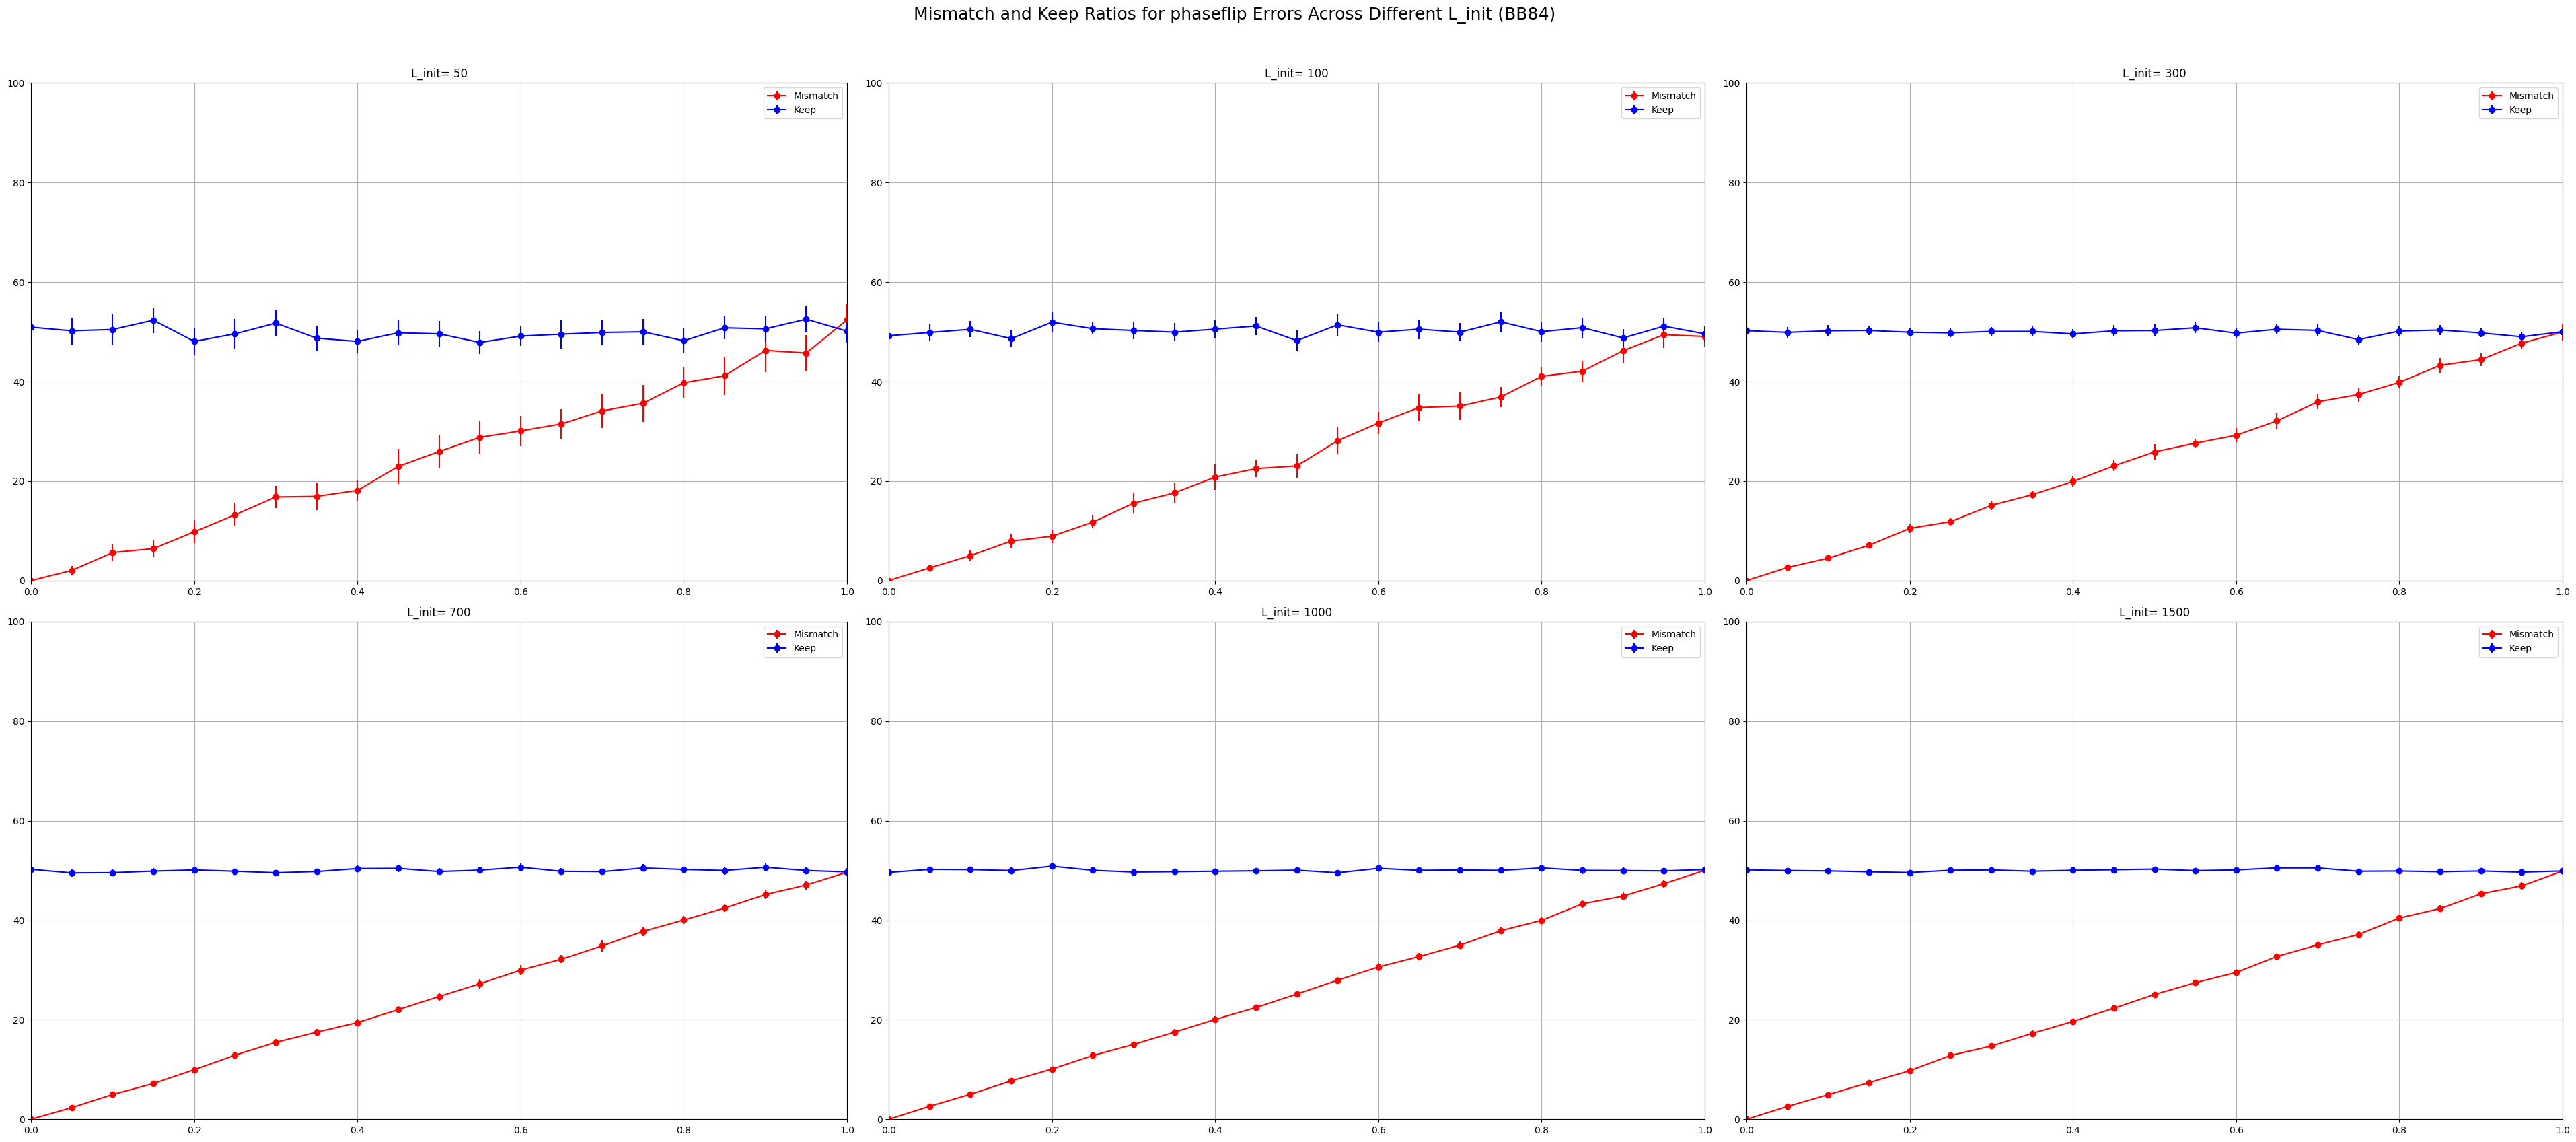

In [33]:
plot_all_mismatch_keep_curves(qc, "phaseflip" , p_values, n_repeats=30, with_eve=False)

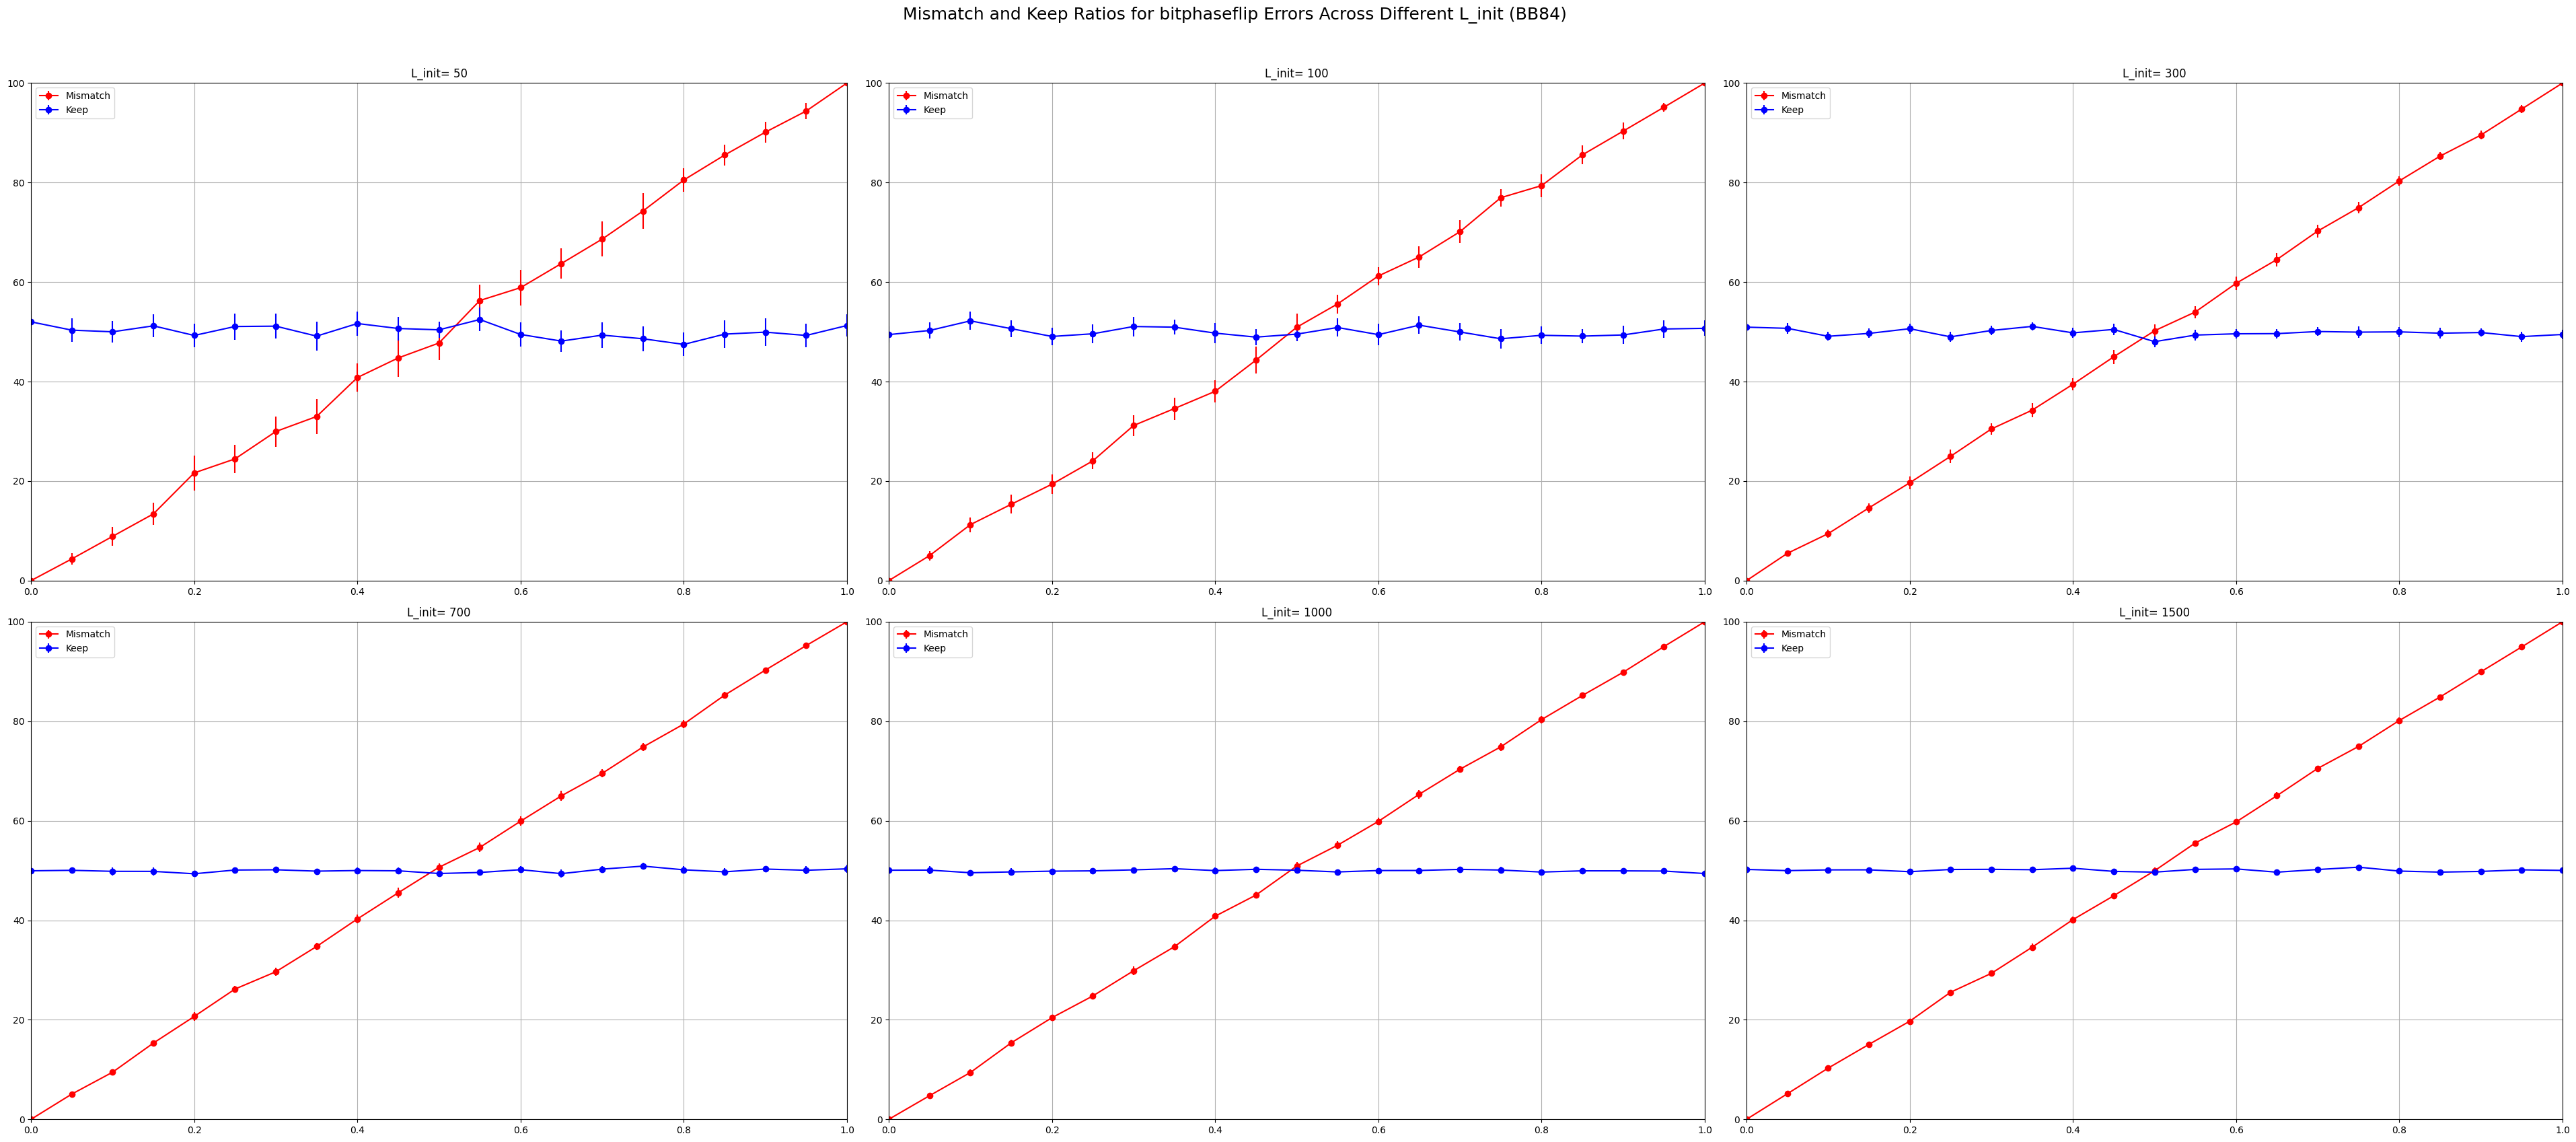

In [34]:
plot_all_mismatch_keep_curves(qc, "bitphaseflip" , p_values, n_repeats=30, with_eve=False)

In [35]:
qc = build_bb84(with_eve=True)
p_values = np.arange(0, 1.05, 0.05)

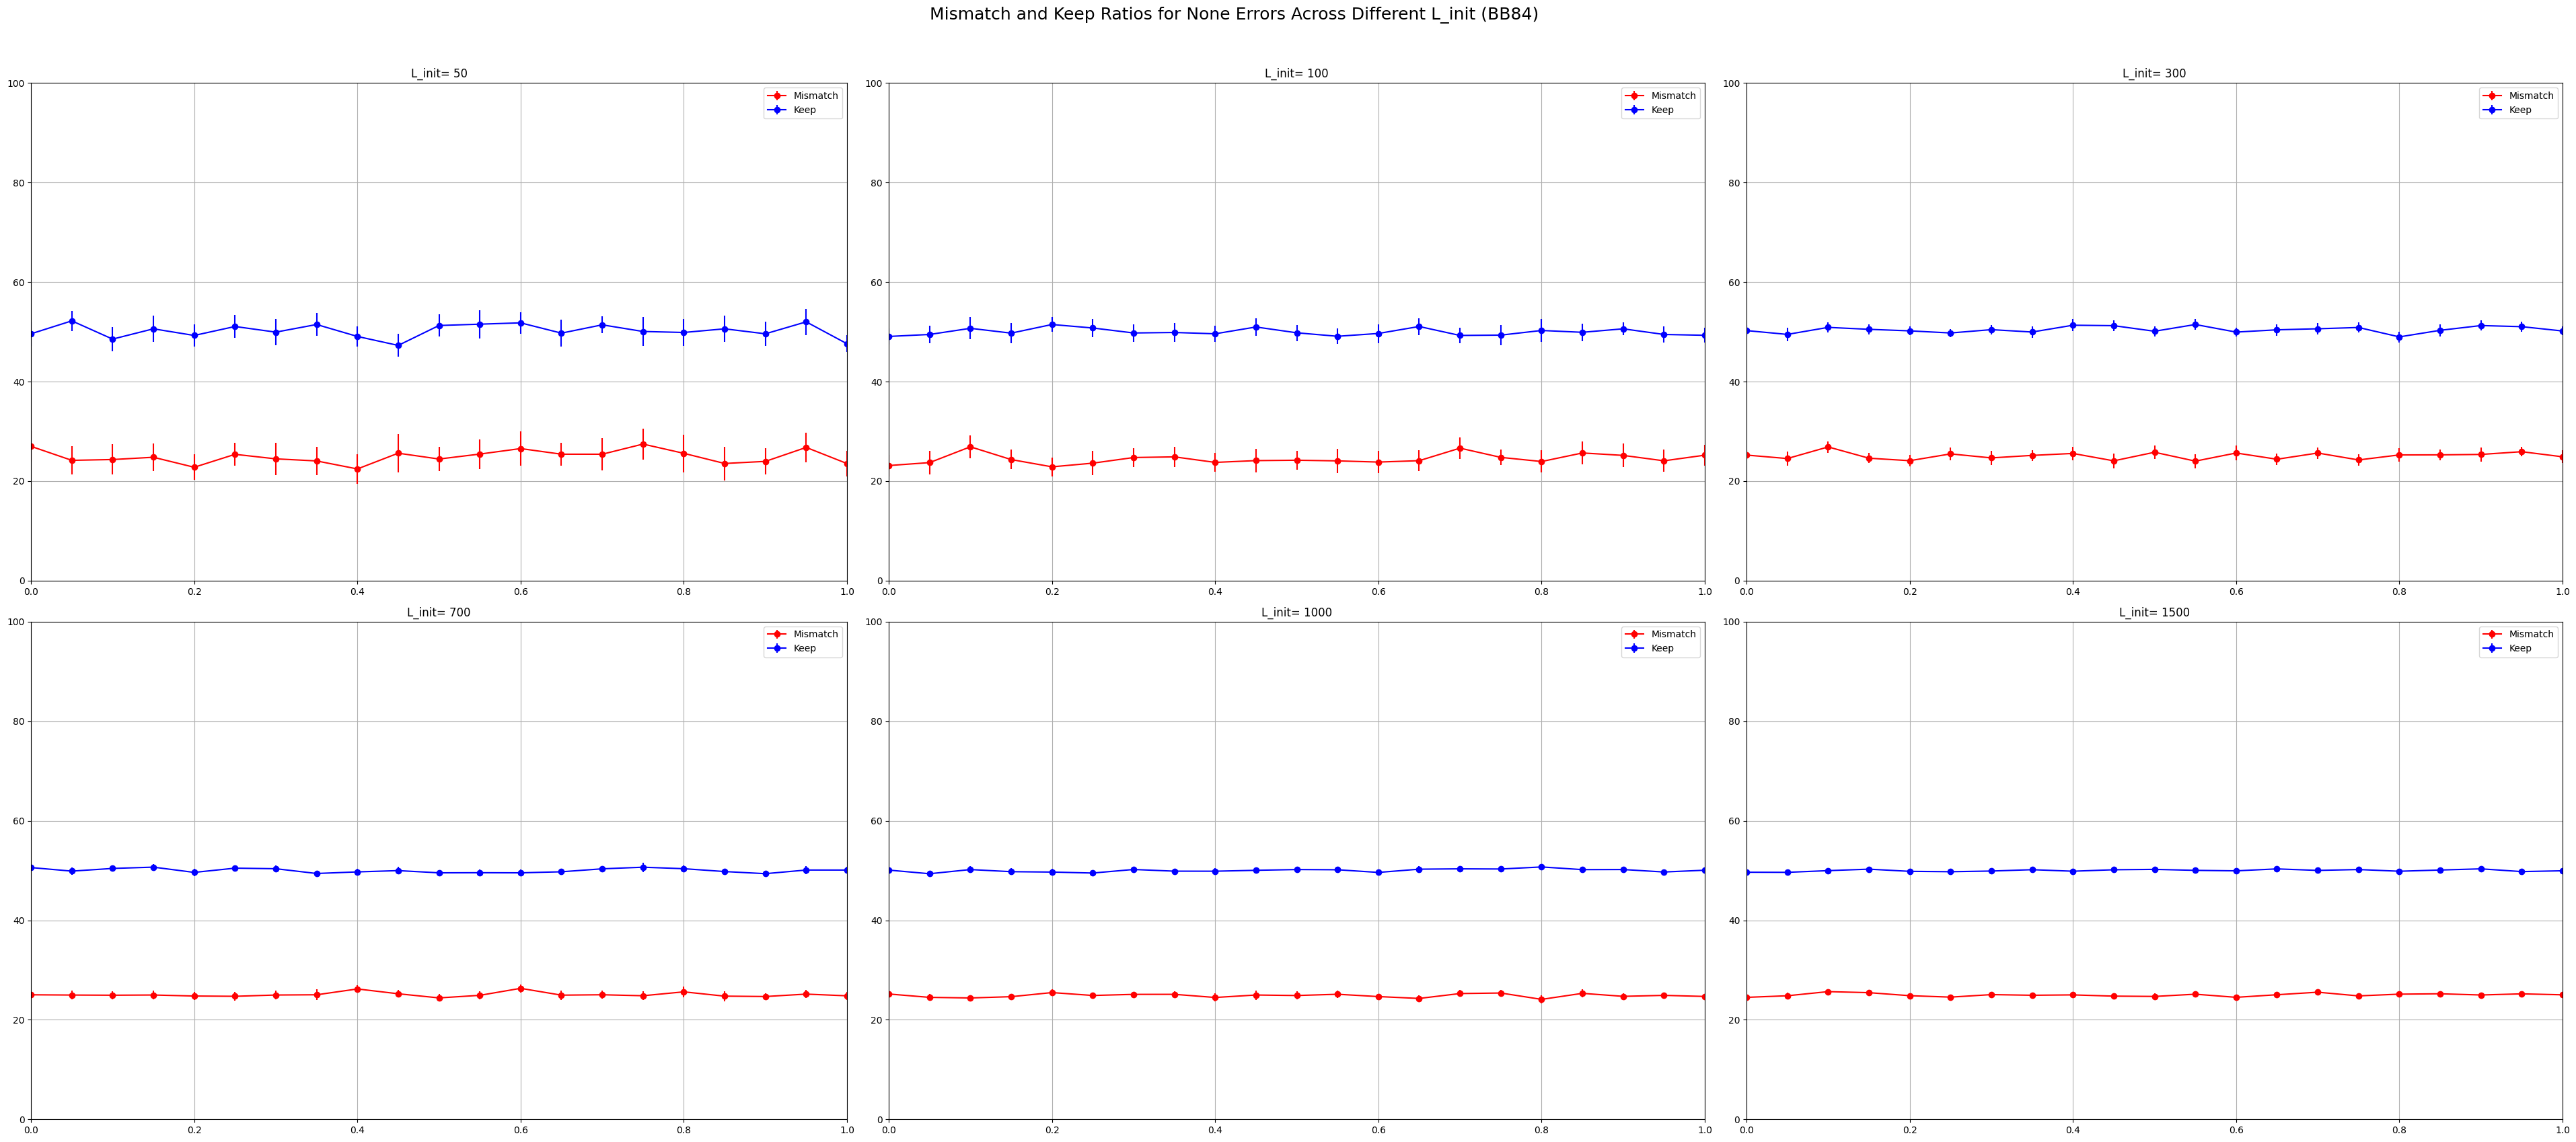

In [36]:
plot_all_mismatch_keep_curves(qc, None , p_values, n_repeats=30, with_eve=True)

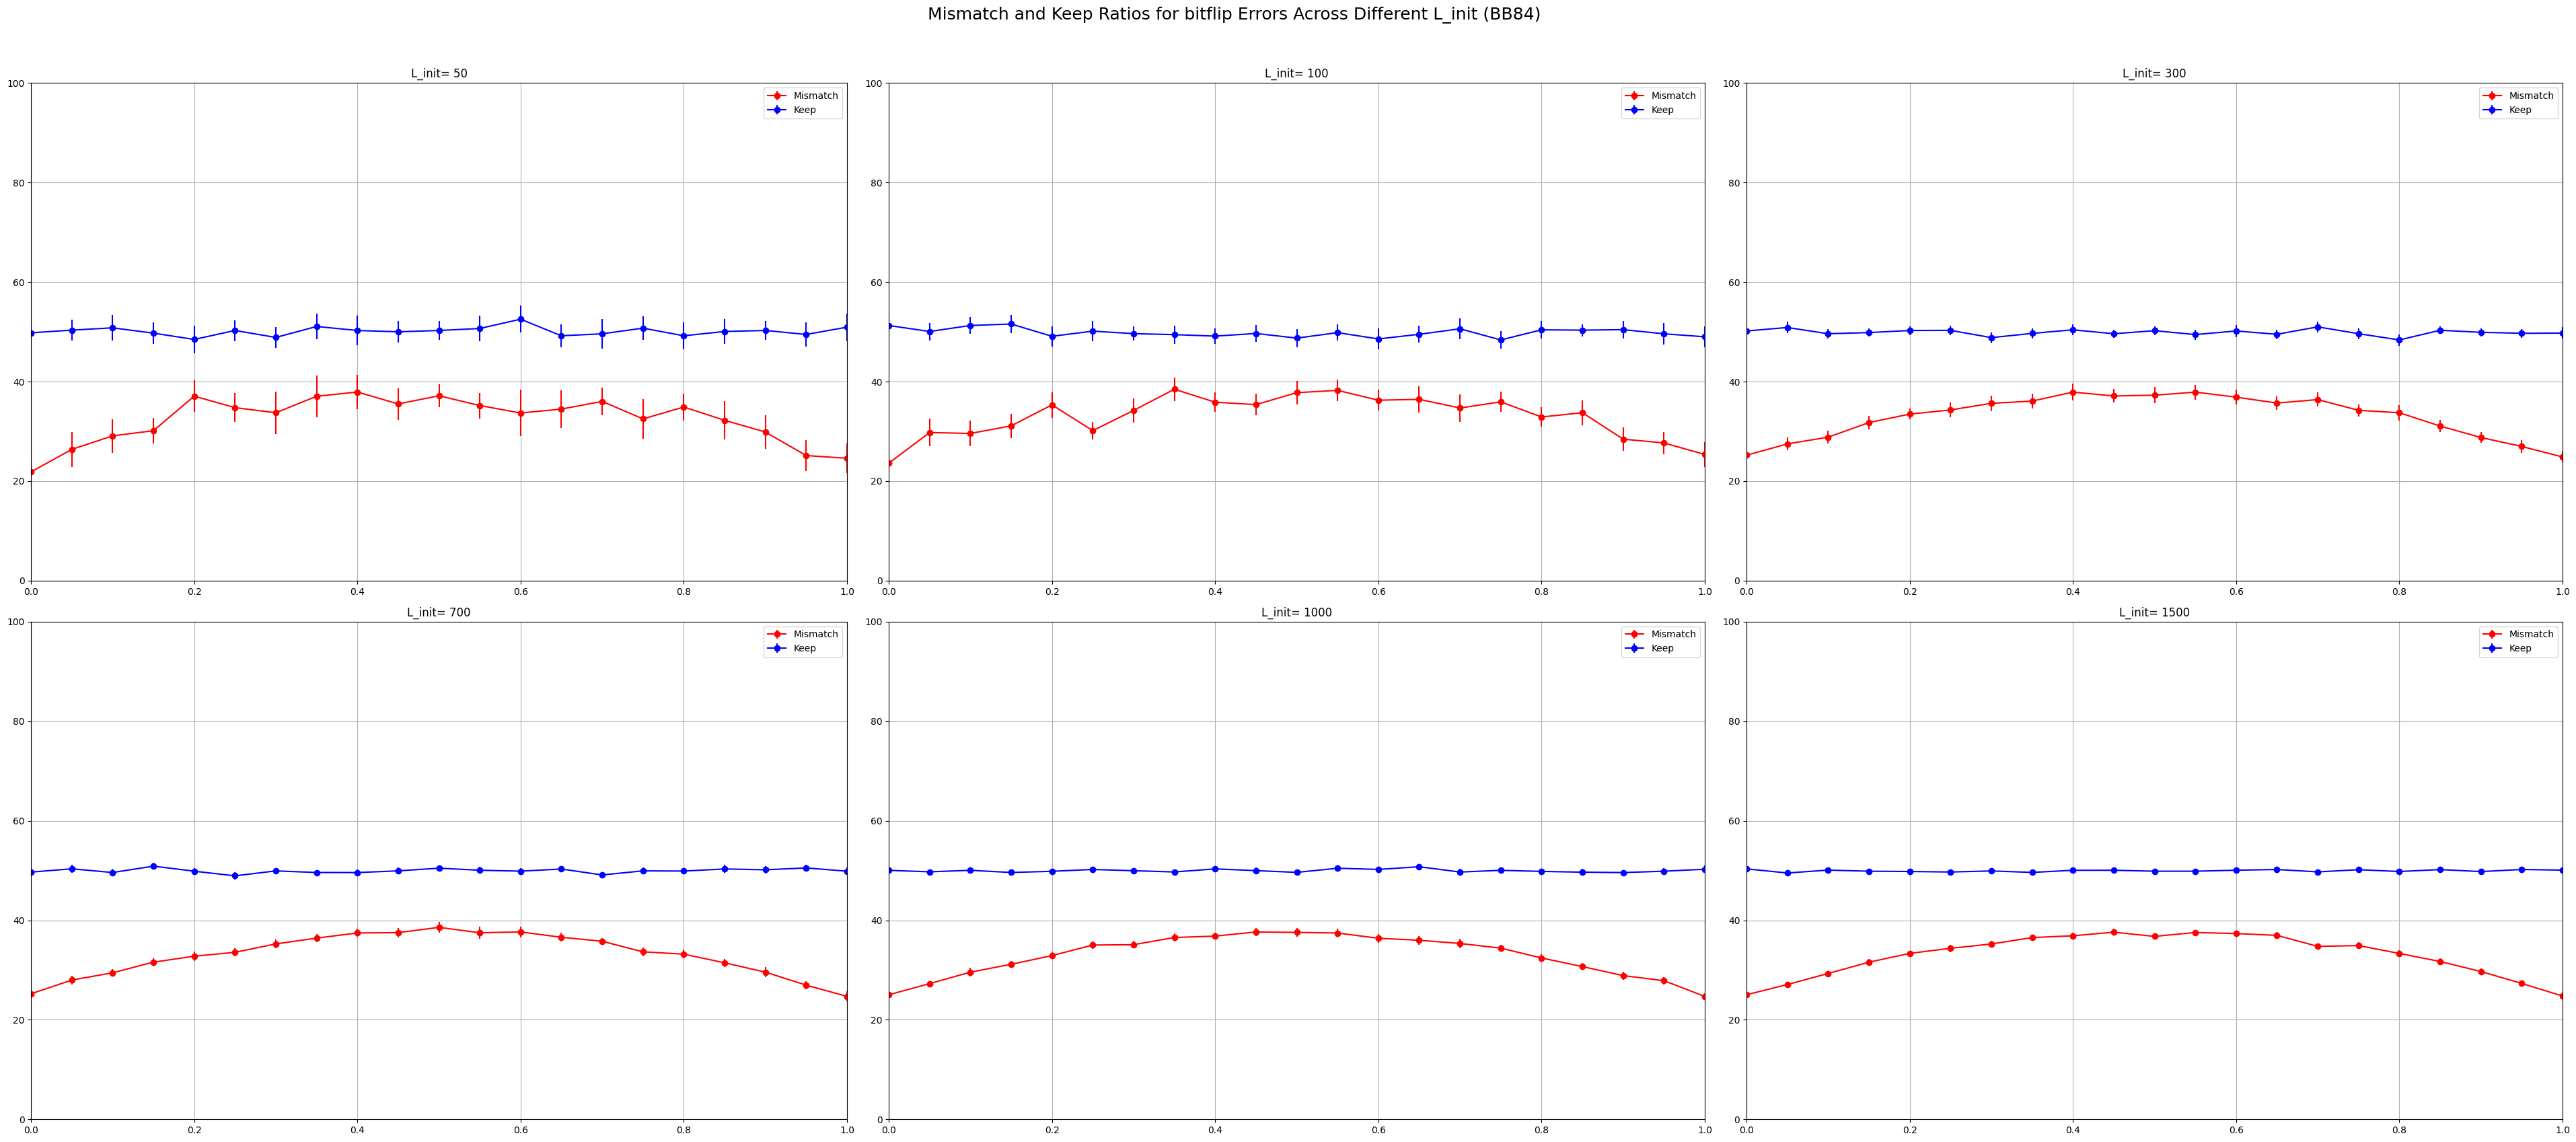

In [37]:
plot_all_mismatch_keep_curves(qc, "bitflip" , p_values, n_repeats=30, with_eve=True)

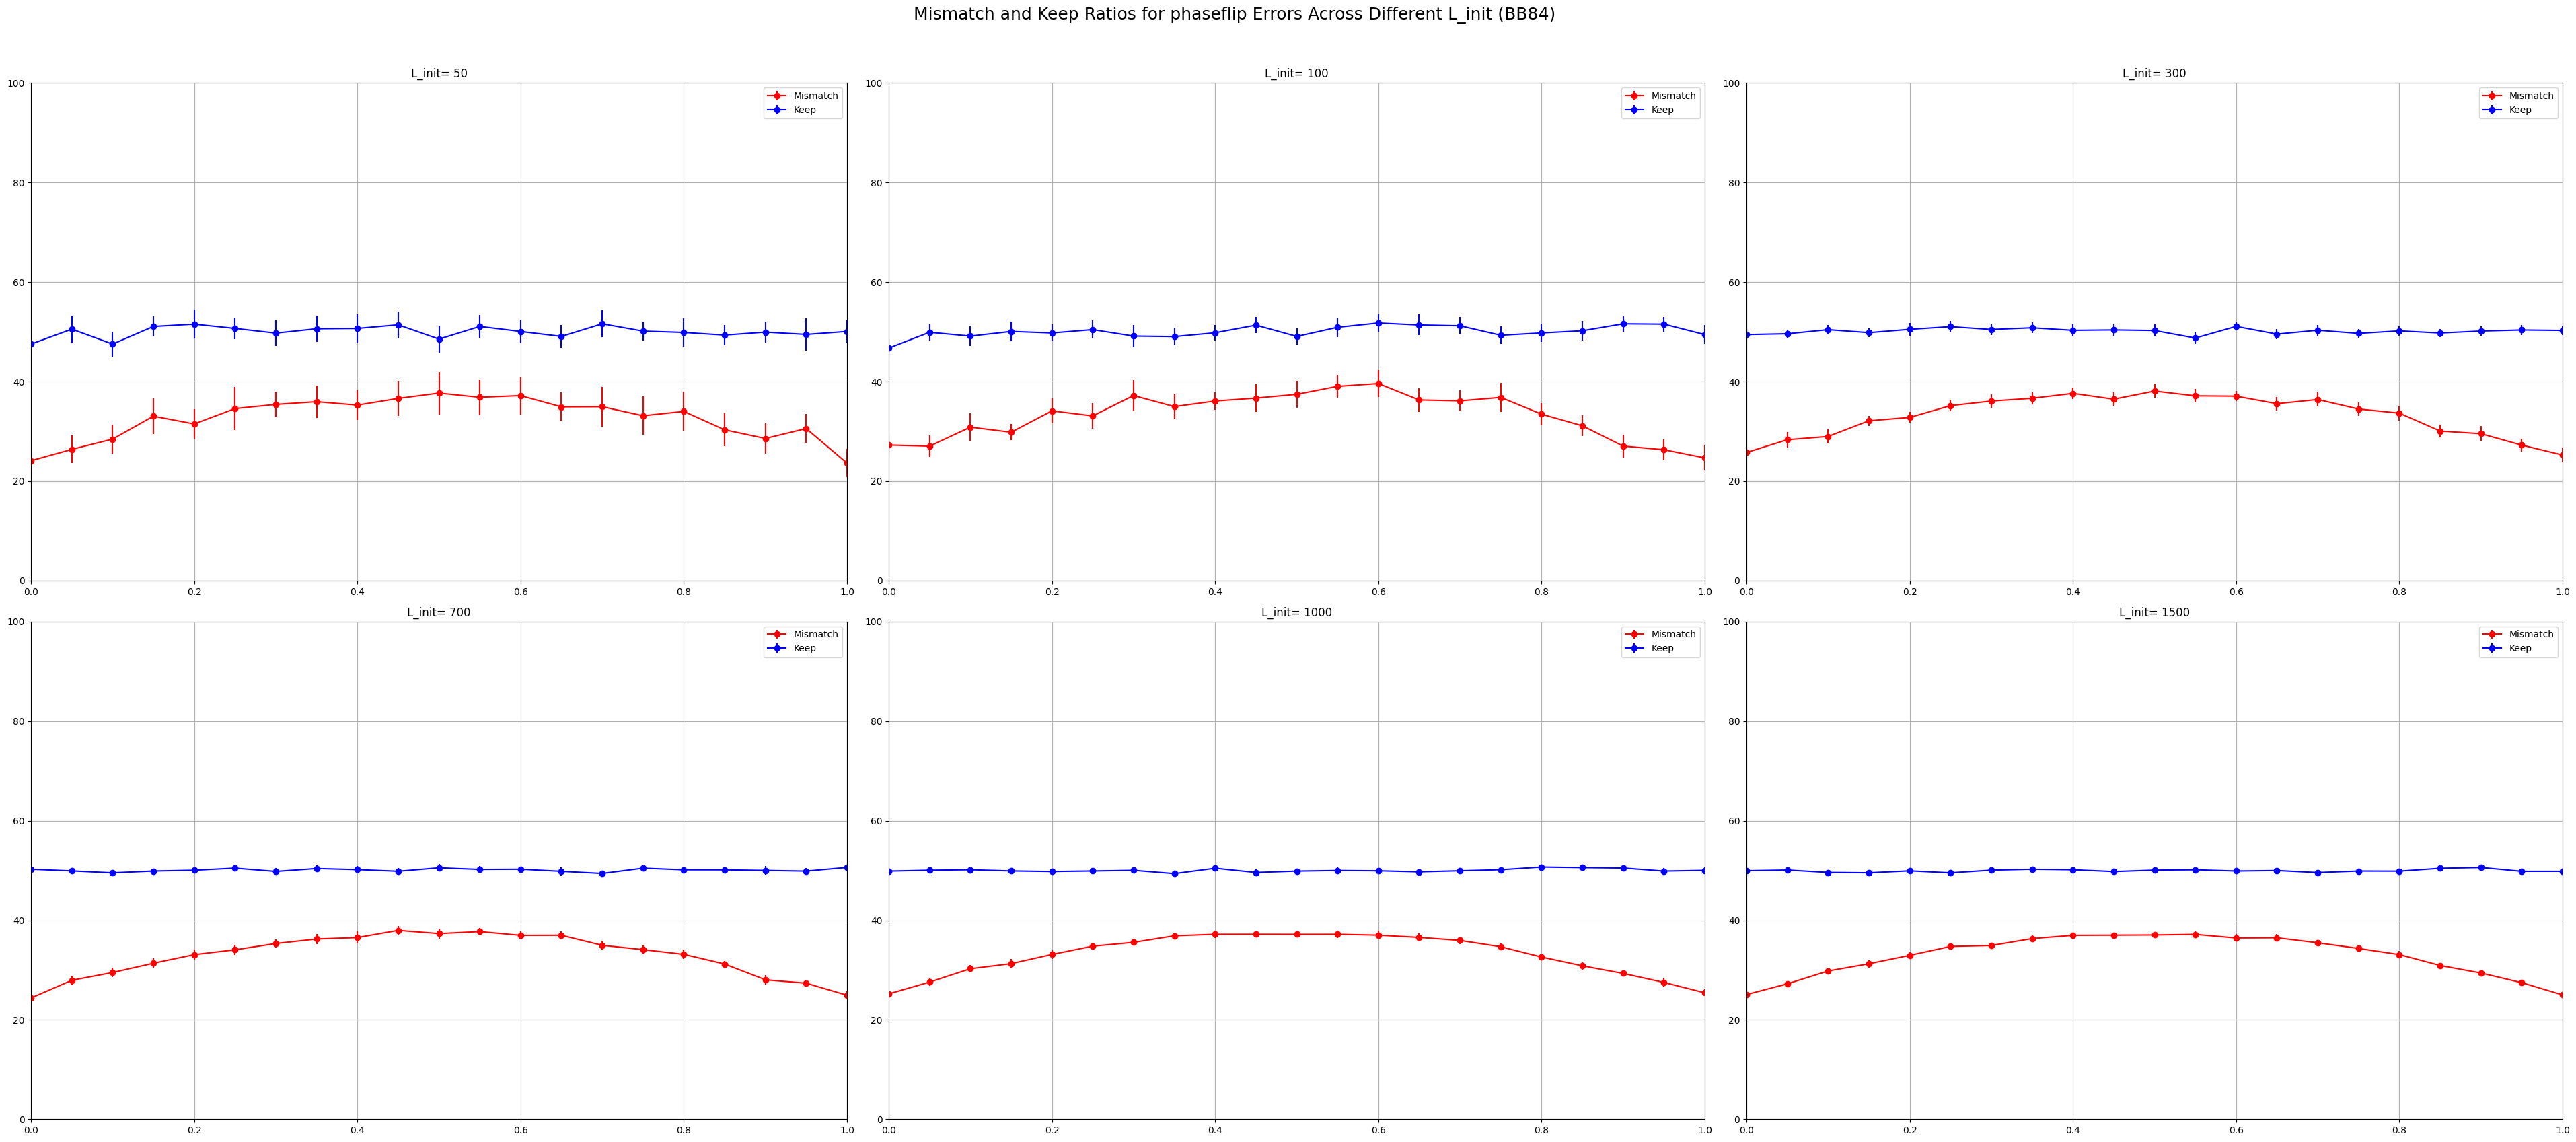

In [38]:
plot_all_mismatch_keep_curves(qc, "phaseflip" , p_values, n_repeats=30, with_eve=True)

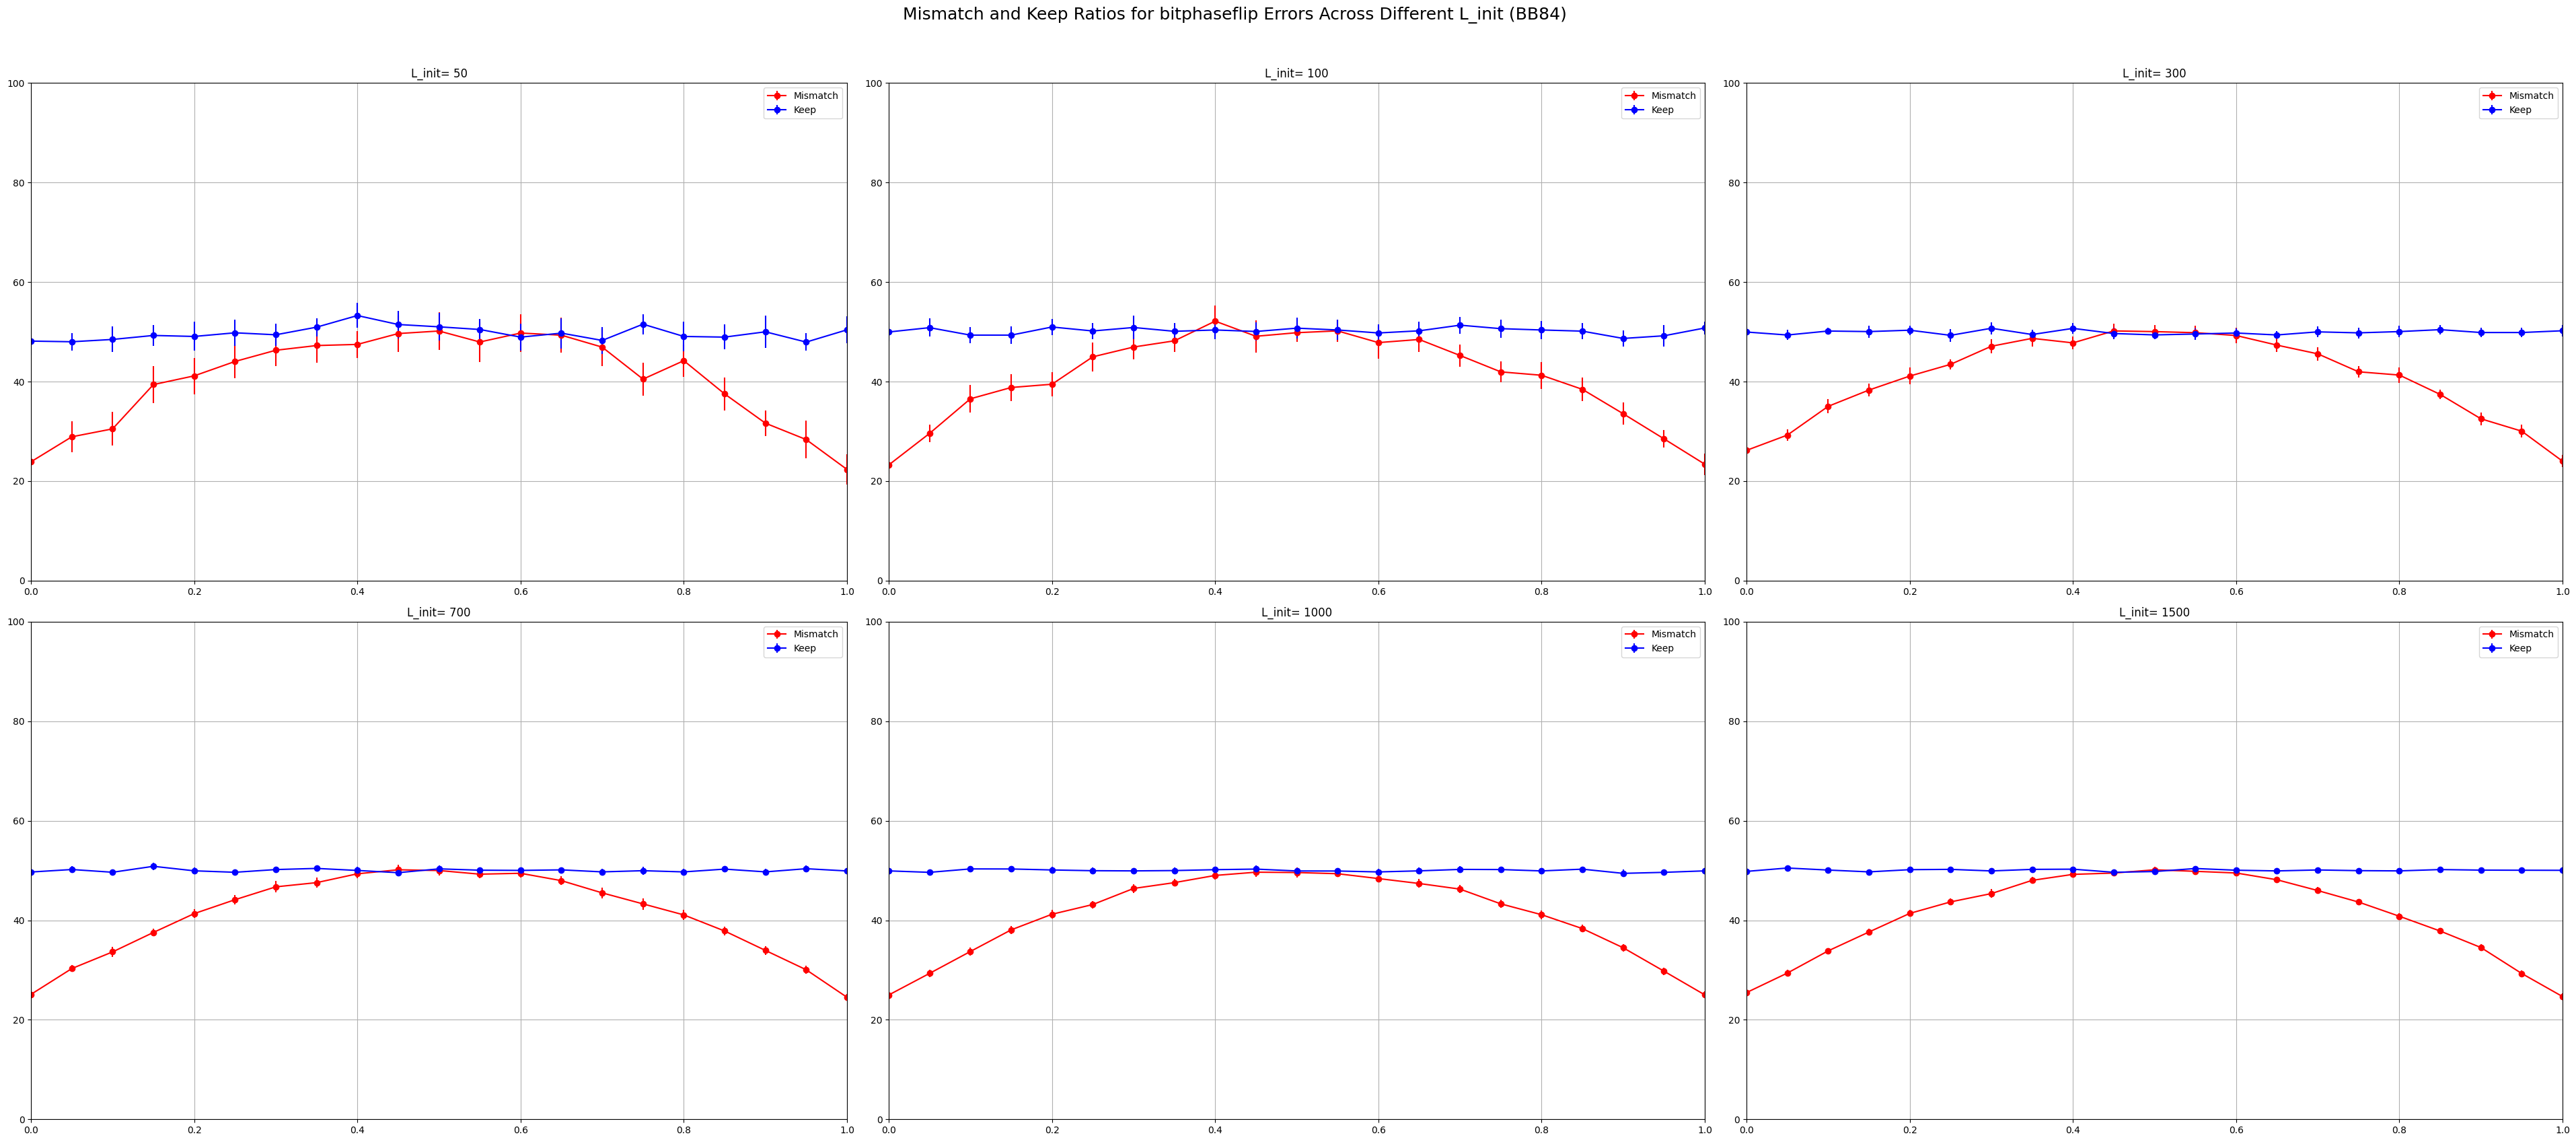

In [39]:
plot_all_mismatch_keep_curves(qc, "bitphaseflip" , p_values, n_repeats=30, with_eve=True)

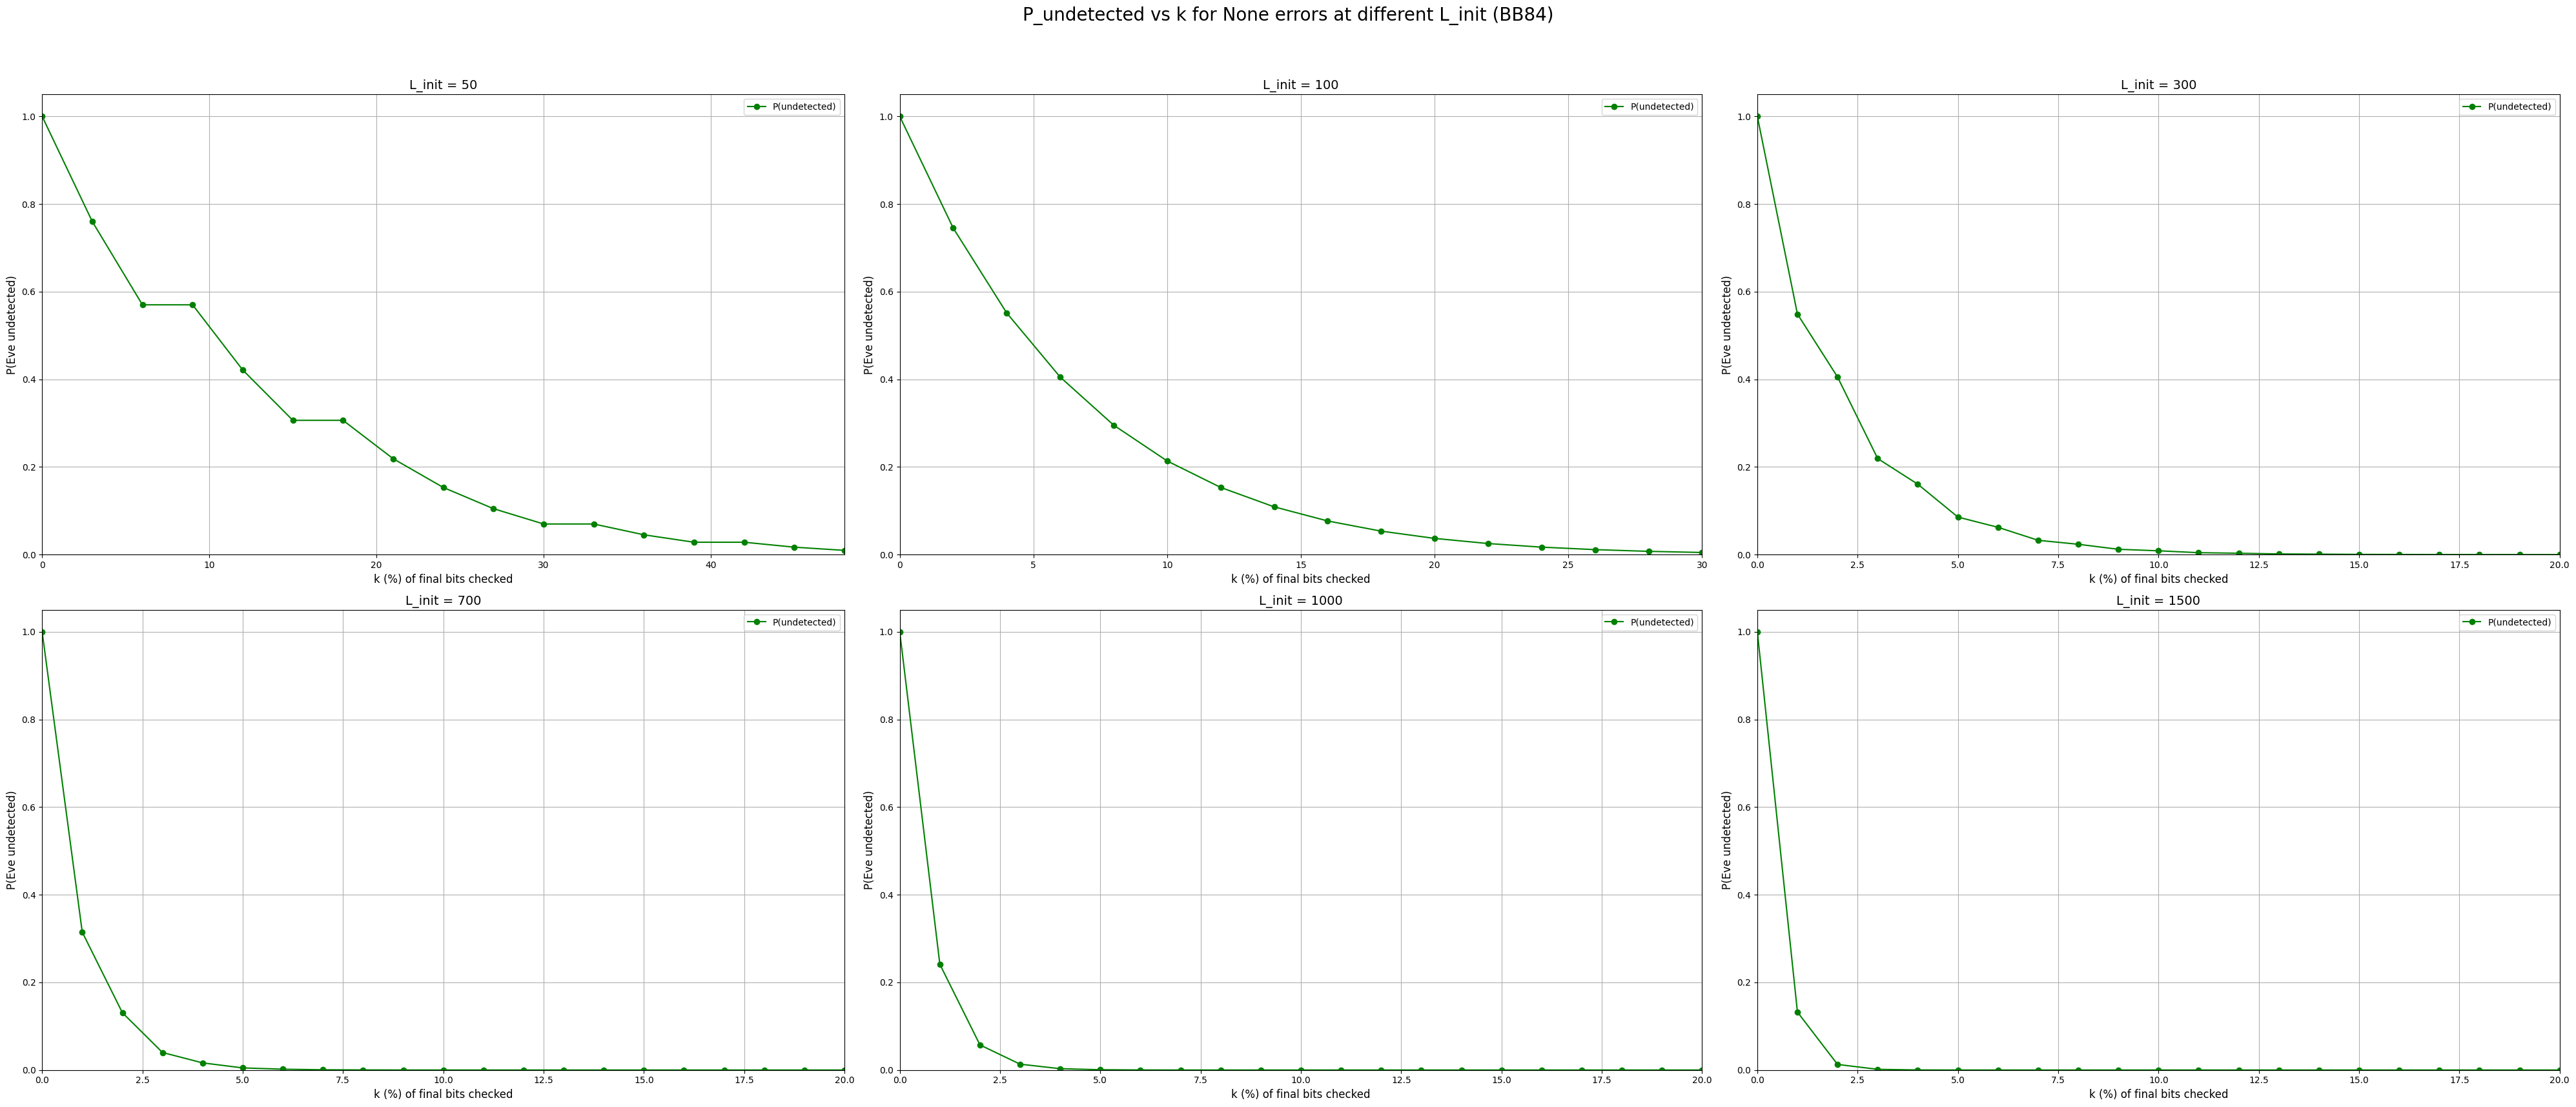

In [40]:
plot_all_p_undetected_curves(qc, noise_type=None, p=0, n_repeats=30, with_eve=True)

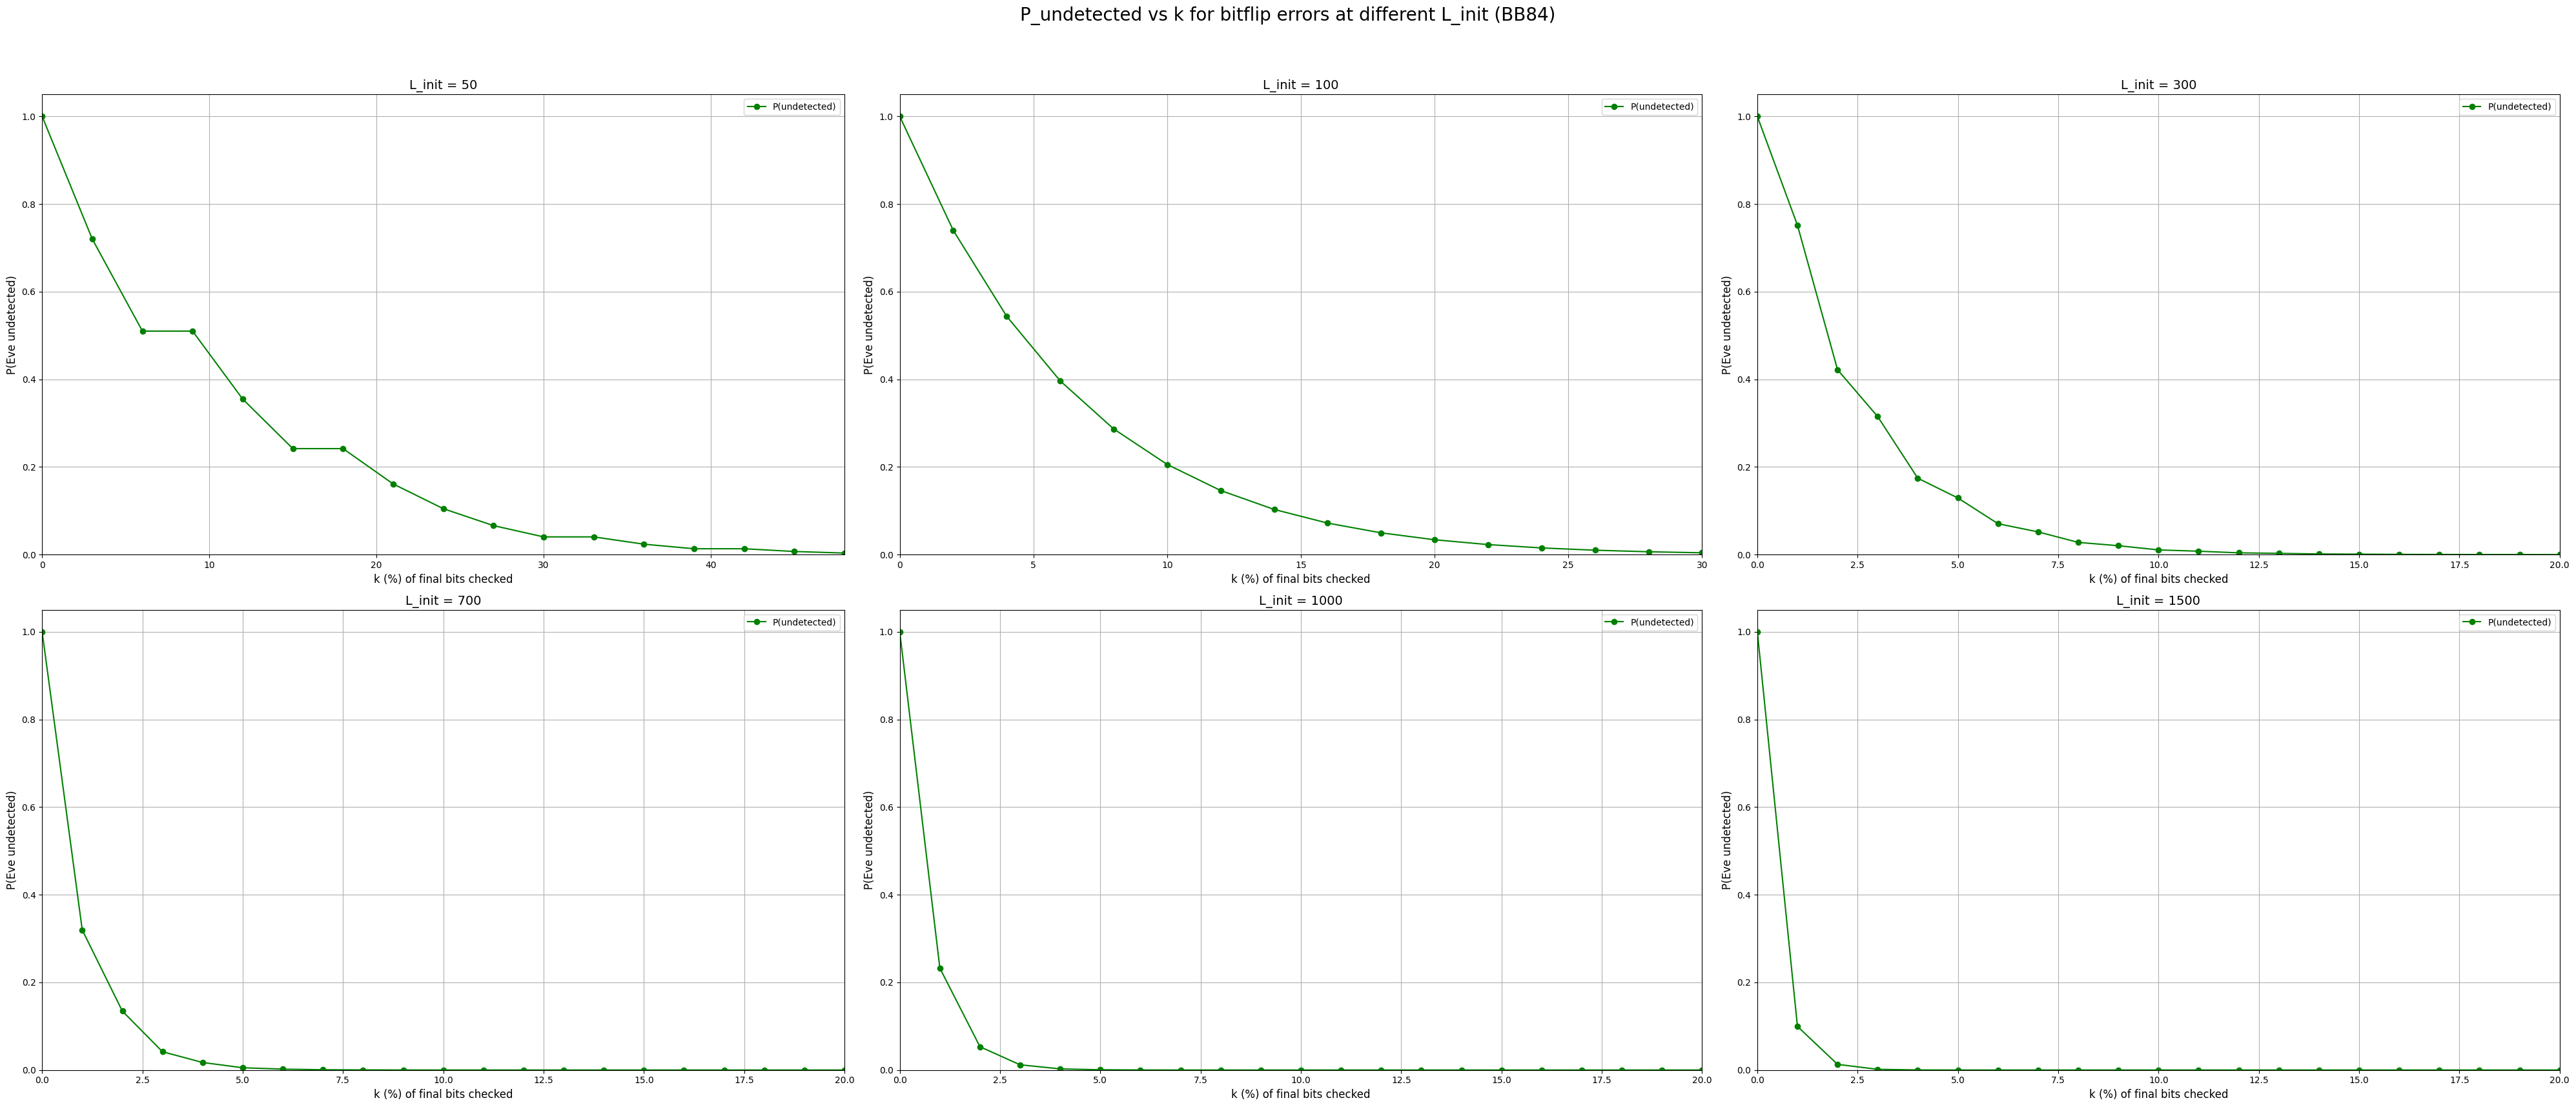

In [41]:
plot_all_p_undetected_curves(qc, noise_type="bitflip", p=0, n_repeats=30, with_eve=True)

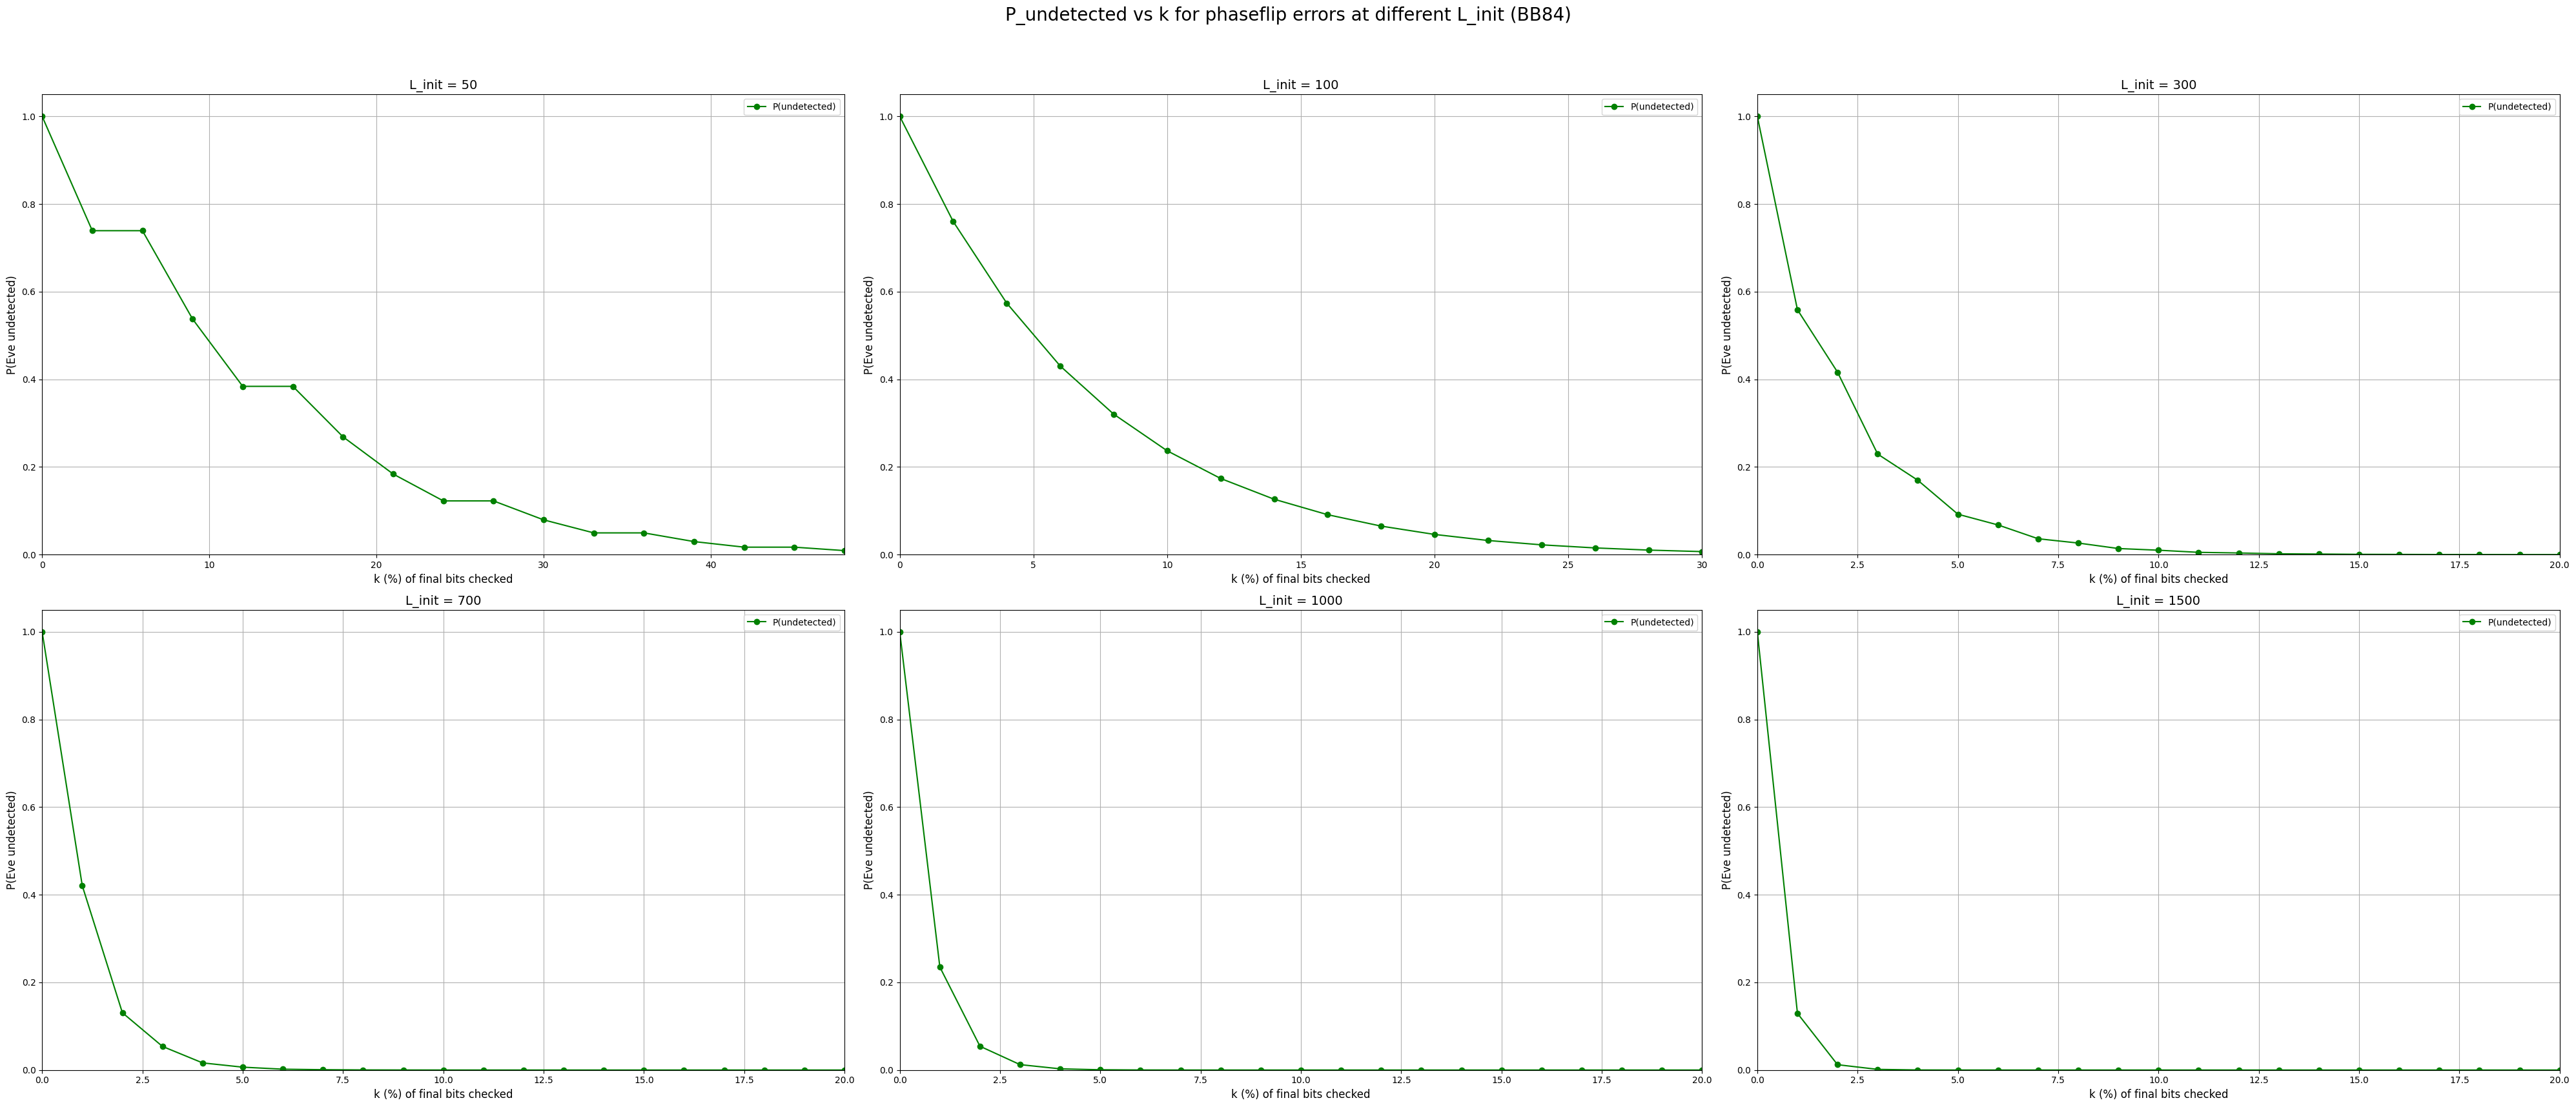

In [42]:
plot_all_p_undetected_curves(qc, noise_type="phaseflip", p=0, n_repeats=30, with_eve=True)

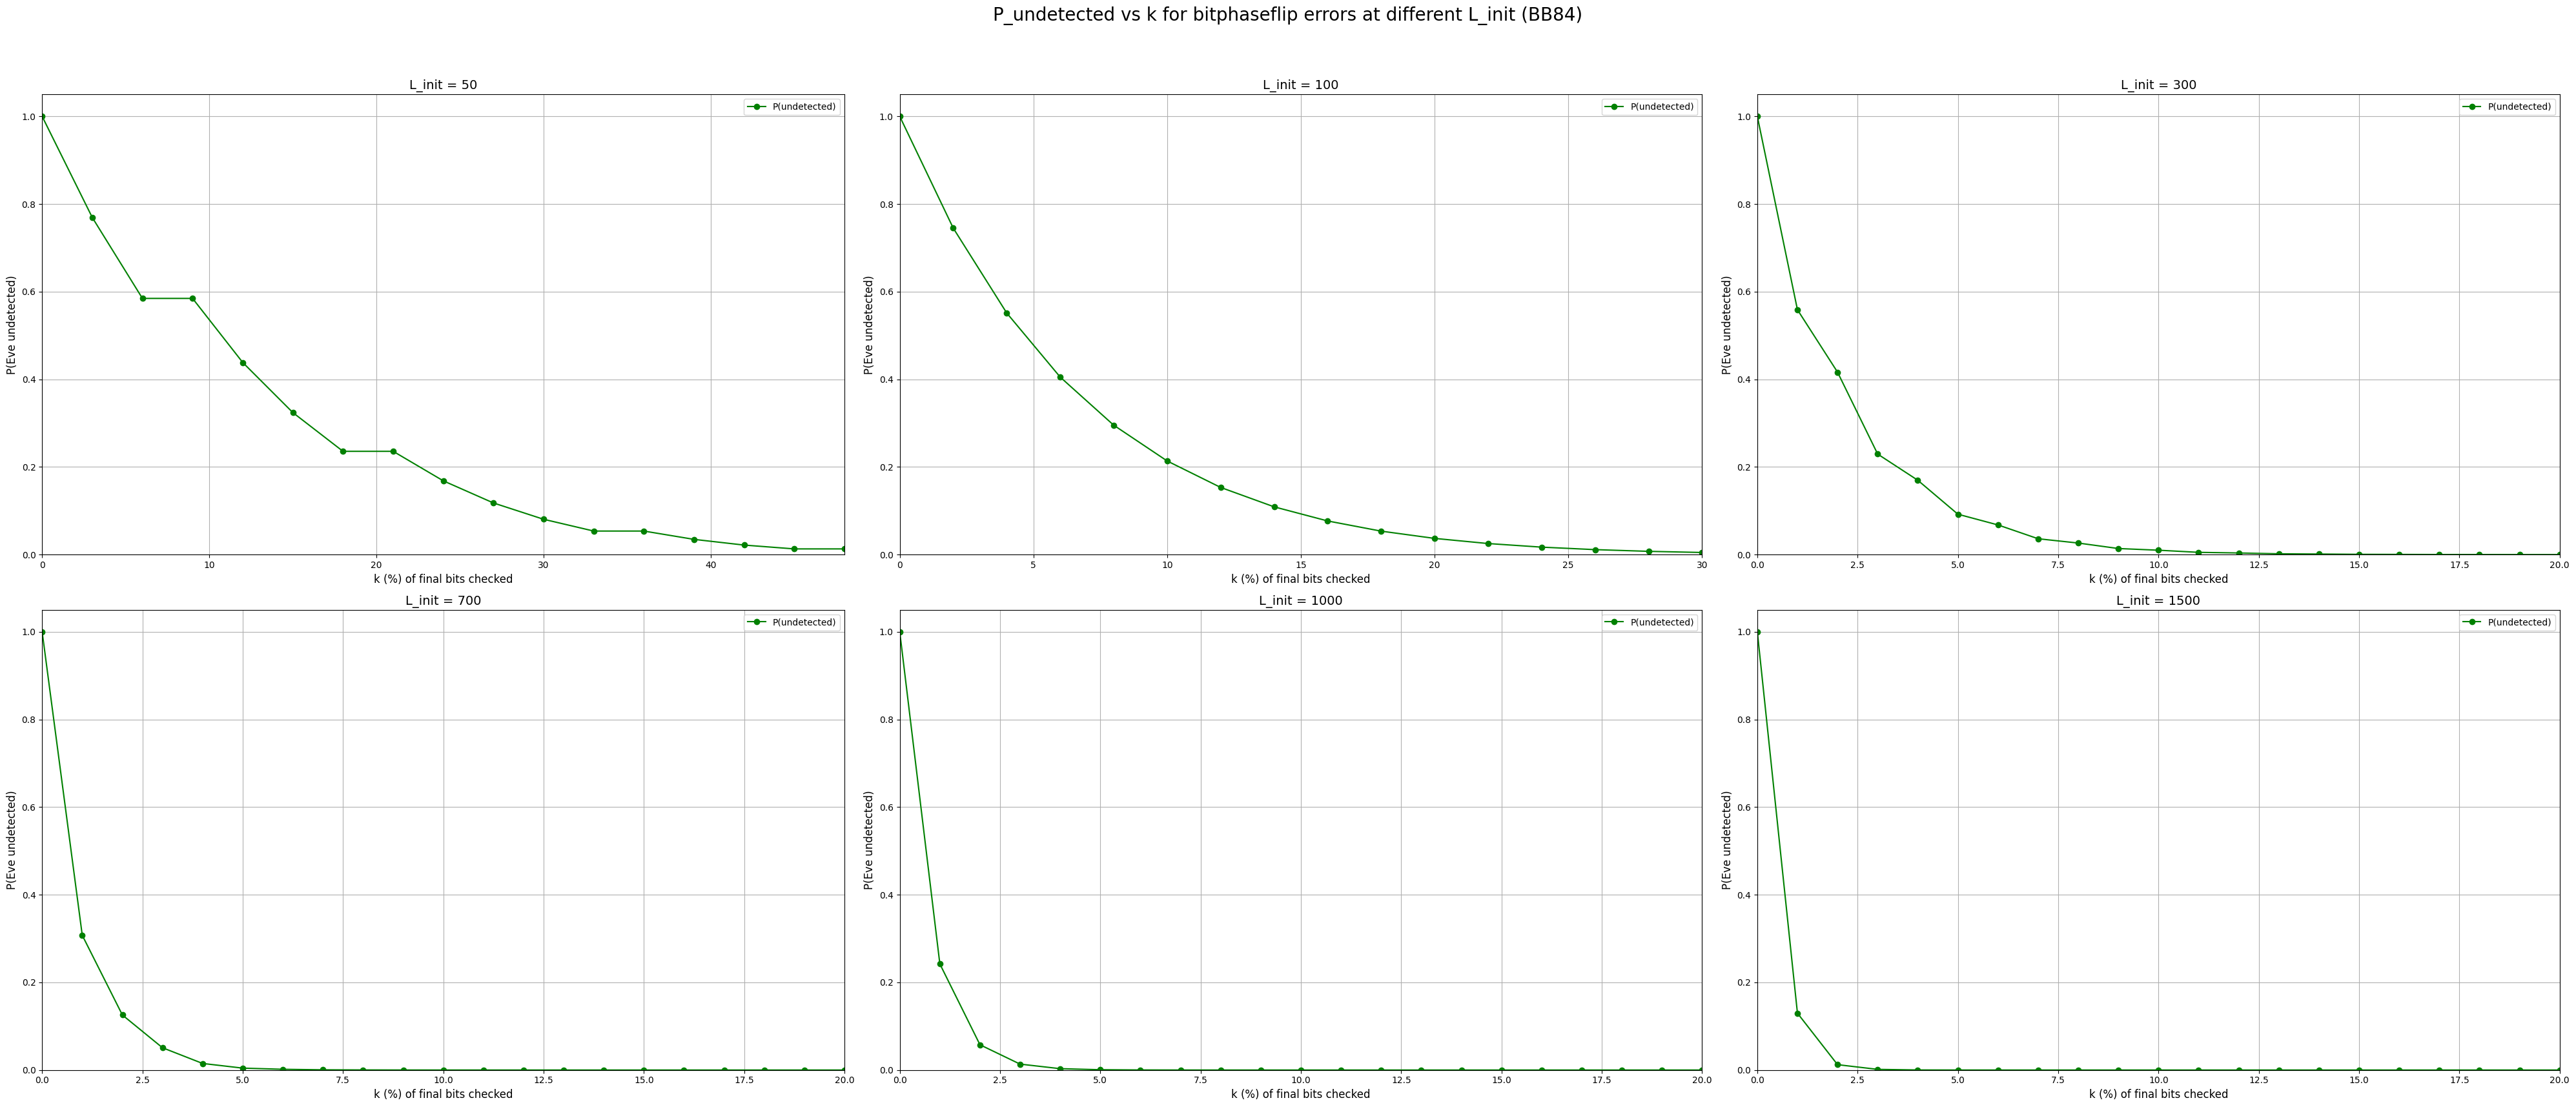

In [43]:
plot_all_p_undetected_curves(qc, noise_type="bitphaseflip", p=0, n_repeats=30, with_eve=True)